In [1]:

# !pip install pandas numpy seaborn matplotlib genshim sklearn
# !pip install kagglehub underthesea tqdm
# !pip install transformer touch re

# !pip install googletrans==4.0.0-rc1


NLTK Parser: [Underthesea](https://underthesea.readthedocs.io/en/latest/readme.html)

Corpus Dataset: [KaggleHub - Pham Tuyet](https://www.kaggle.com/datasets/phamtuyet/text-classification?select=text_tokenizer.xlsx)

Stopword Dataset: [KaggleHub - L3VIEVIL](https://www.kaggle.com/datasets/linhlpv/vietnamese-stopwords)



In [2]:
# Core Imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import warnings
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE

# NLP & Utilities 
import kagglehub
from underthesea import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm

# Optional Google Translator
translator = None
try:
    from googletrans import Translator
    translator = Translator()
    print("Google Translator initialized.")
except ImportError:
    print("googletrans not installed, skipping translation.")
except Exception as e:
    print(f"Could not initialize translator: {e}")

warnings.simplefilter("ignore")  
tqdm.pandas(desc="Processing")   

# Define folders for saving results
PKL_FOLDER = 'pkl_folder'
DATA_FOLDER = 'data'

os.makedirs(PKL_FOLDER, exist_ok=True)
os.makedirs(DATA_FOLDER, exist_ok=True)
print(f"Folders ready: PKL -> {PKL_FOLDER}, DATA -> {DATA_FOLDER}")




def translate_words(words_list):
    translations = []
    if not translator: 
        return ["N/A"] * len(words_list)
    
    for word in words_list:
        try:
            translated = translator.translate(word, src='vi', dest='en')
            if hasattr(translated, 'text'):
                translations.append(translated.text)
            else:
                translations.append("N/A")
        except Exception as e:

            translations.append("Error")
    return translations

print("Helper function 'translate_words' is defined.")




Google Translator initialized.
Folders ready: PKL -> pkl_folder, DATA -> data
Helper function 'translate_words' is defined.


In [3]:
# Loading model for 10 and 11

file_path = "model/word2vec_vi_words_100dims.txt"

print(f"Loading Word2Vec model from: {file_path}")
w2v_model = KeyedVectors.load_word2vec_format(file_path, binary=False)
print("Model loaded!")



fasttext_path = "model/cc.vi.300.vec" 


print(f"Loading FastText Model from: {fasttext_path}")
model_ft = KeyedVectors.load_word2vec_format(fasttext_path, binary=False)
print("FastText Model Loaded.")

# Load PhoBERT Model and Tokenizer 
from transformers import AutoModel, AutoTokenizer
import torch

print("Loading PhoBERT model and tokenizer...")

phobert_model = AutoModel.from_pretrained("vinai/phobert-base")
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
print("PhoBERT loaded")
phobert_embeddings = phobert_model.get_input_embeddings()
phobert_vocab = phobert_tokenizer.get_vocab()
phobert_inv_vocab = {v: k for k, v in phobert_vocab.items()} 

    



Loading Word2Vec model from: model/word2vec_vi_words_100dims.txt
Model loaded!
Loading FastText Model from: model/cc.vi.300.vec
FastText Model Loaded.
Loading PhoBERT model and tokenizer...
PhoBERT loaded


In [4]:

DATASET_NAME = 'phamtuyet/text-classification'
EXCEL_FILE = 'text_tokenizer.xlsx'
N_SAMPLES_PER_CATEGORY = 2000  # Number of samples per category

# Define the English mapping before loading the data
LABEL_MAPPING = {
    'chinh-tri': 'Politics',
    'doi-song': 'Daily_Life',
    'giao-duc': 'Education',
    'kinh-doanh': 'Business',
    'phap-luat': 'Law',
    'suc-khoe': 'Health',
    'the-gioi': 'World',
    'the-thao': 'Sports'
}


vn_df = None 

# Download or locate dataset
try:
    news_dataset_path = kagglehub.dataset_download(DATASET_NAME)
    print(f"Dataset downloaded/located via KaggleHub: {news_dataset_path}")
except Exception as e:
    print(f"Error downloading/finding dataset: {e}")
    news_dataset_path = None

# Load Excel file if available
if news_dataset_path and os.path.exists(os.path.join(news_dataset_path, EXCEL_FILE)):
    file_path = os.path.join(news_dataset_path, EXCEL_FILE)
    print(f"Loading dataset from: {file_path}")
    
    full_news_df = pd.read_excel(file_path, header=None, names=['content', 'label'])
    
    full_news_df = full_news_df[full_news_df['label'] != 'label'].copy()
    
    # Create subset
    vn_df_news_subset = full_news_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(min(len(x), N_SAMPLES_PER_CATEGORY), random_state=42)
    )
    
    vn_df = vn_df_news_subset.reset_index(drop=True)

    # Apply English label mapping 
    vn_df['label'] = vn_df['label'].map(LABEL_MAPPING)
    
    print(f"Subset created successfully! Total rows: {len(vn_df)}, Categories: {vn_df['label'].nunique()}")
    print("\nCategory distribution:")
    print(vn_df['label'].value_counts())
else:
    print("Error: Could not locate the dataset file. Check the path or KaggleHub download.")


Dataset downloaded/located via KaggleHub: C:\Users\ducth\.cache\kagglehub\datasets\phamtuyet\text-classification\versions\1
Loading dataset from: C:\Users\ducth\.cache\kagglehub\datasets\phamtuyet\text-classification\versions\1\text_tokenizer.xlsx
Subset created successfully! Total rows: 16000, Categories: 8

Category distribution:
label
Politics      2000
Daily_Life    2000
Education     2000
Business      2000
Law           2000
Health        2000
World         2000
Sports        2000
Name: count, dtype: int64


# Preprocessing and Tokenize

In [5]:

import re

TOKENIZED_FILE = os.path.join(DATA_FOLDER, 'vn_news_tokenized.pkl')

# If tokenized version exists, load it
if os.path.exists(TOKENIZED_FILE):
    print(f"Loading tokenized dataset from: {TOKENIZED_FILE}")
    vn_df = pd.read_pickle(TOKENIZED_FILE)
    print("Tokenized dataset loaded successfully!")
    
else:
    # Preprocessing function
    def preprocess_vn_text(text):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = re.sub(r"\d+", "", text)                 # Remove numbers
        text = re.sub(r"[^\w\s_]", "", text)            # Remove punctuation except _
        text = re.sub(r"\s+", " ", text).strip()        # Remove extra whitespace
        return text

    print("Preprocessing and tokenizing Vietnamese news content...")
    vn_df['clean_content'] = vn_df['content'].progress_apply(preprocess_vn_text)
    print("Preprocessing completed!")

    # Save tokenized version for future runs
    vn_df.to_pickle(TOKENIZED_FILE)
    print(f"Tokenized dataset saved to: {TOKENIZED_FILE}")

# Quick check
print(vn_df[['content', 'clean_content']].head(3))


Loading tokenized dataset from: data\vn_news_tokenized.pkl
Tokenized dataset loaded successfully!
                                             content  \
0  Hôm_nay , Tỉnh_ủy Quảng_Bình tổ_chức hội_nghị ...   
1  Từ ngày 29 - 31/5 , tại Hà_Nội , UB Kiểm_tra T...   
2  Sau 1 tháng , Bộ Nội_vụ và Trung_ương Đoàn đã ...   

                                       clean_content  
0  hôm_nay tỉnh_ủy quảng_bình tổ_chức hội_nghị lầ...  
1  từ ngày tại hà_nội ub kiểm_tra tư đã họp kỳ bí...  
2  sau tháng bộ nội_vụ và trung_ương đoàn đã nhận...  


# Working on Stopword

In [6]:
STOPWORDS_TOKENIZED_FILE = os.path.join(DATA_FOLDER, 'vn_stopwords_tokenized.pkl')

print("Loading Vietnamese stopwords...")
stopword_path = kagglehub.dataset_download("linhlpv/vietnamese-stopwords")
stopword_file = os.path.join(stopword_path, "vietnamese-stopwords.txt")

if os.path.exists(STOPWORDS_TOKENIZED_FILE):
    print(f"Loading tokenized stopwords from {STOPWORDS_TOKENIZED_FILE}...")
    with open(STOPWORDS_TOKENIZED_FILE, 'rb') as f:
        vietnamese_stopwords_set = pickle.load(f)
    print(f"Loaded {len(vietnamese_stopwords_set)} tokenized stopwords.")

    
else:
    stopword_df = pd.read_csv(stopword_file, header=None, names=['word'], encoding='utf-8')
    # Clean: strip whitespace, lowercase, remove empty strings
    vietnamese_stopwords_set = set(
        stopword_df['word'].str.strip().str.lower().replace('', pd.NA).dropna().tolist()
    )
    print(f"Loaded {len(vietnamese_stopwords_set)} raw stopwords.")
    print("Tokenizing Vietnamese stopwords...")
    vietnamese_stopwords_set_tokenized = set()
    for word in vietnamese_stopwords_set:
        tokens = word_tokenize(word.lower(), format="text").split()
        vietnamese_stopwords_set_tokenized.update(tokens)
    vietnamese_stopwords_set = vietnamese_stopwords_set_tokenized

    # Save for future runs
    with open(STOPWORDS_TOKENIZED_FILE, 'wb') as f:
        pickle.dump(vietnamese_stopwords_set, f)
    print(f"Tokenized stopwords saved to {STOPWORDS_TOKENIZED_FILE} ({len(vietnamese_stopwords_set)} words).")


Loading Vietnamese stopwords...
Loading tokenized stopwords from data\vn_stopwords_tokenized.pkl...
Loaded 816 tokenized stopwords.


# Question 6: Analysis using Armano et al.



In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import os


TASK6_PKL = os.path.join(PKL_FOLDER, 'task6.pkl') 

# Check for cache or run calculation
if os.path.exists(TASK6_PKL):
    # Load from cache
    print(f"Loading 'results_df' from cache: {TASK6_PKL}")
    results_df = pd.read_pickle(TASK6_PKL)

else:
        
    print("Cache not found. Running calculation...")
    
    # Vectorize the Text
    vectorizer = CountVectorizer(binary=True)
    X_binary = vectorizer.fit_transform(vn_df['clean_content'])
    vocabulary = vectorizer.get_feature_names_out()
    
    # Get labels
    y_labels = vn_df['label']
    categories = y_labels.unique()
    
    all_results = []
    
    # Calculate Delta and Phi 
    for category_C in categories:
        indices_C = (y_labels == category_C)
        indices_C_bar = (y_labels != category_C)

        N_C = indices_C.sum()
        N_C_bar = indices_C_bar.sum()

        if N_C == 0 or N_C_bar == 0:
            continue
            
        X_C = X_binary[indices_C, :]
        X_C_bar = X_binary[indices_C_bar, :]
        
        TP_vector = np.asarray(X_C.sum(axis=0)).flatten()
        FP_vector = np.asarray(X_C_bar.sum(axis=0)).flatten()
        TN_vector = N_C_bar - FP_vector

        # Vectorized calculations
        sensitivity_vec = TP_vector / N_C
        fallout_vec = FP_vector / N_C_bar
        specificity_vec = TN_vector / N_C_bar
        
        delta_vec = sensitivity_vec- fallout_vec
        phi_vec = sensitivity_vec - specificity_vec
        
        
        cat_results = pd.DataFrame({
            'word':vocabulary,
            'label': category_C,
            'delta': delta_vec ,
            'phi': phi_vec
        })
        all_results.append(cat_results)
        
    # save results
    results_df = pd.concat(all_results, ignore_index=True)
    results_df.to_pickle(TASK6_PKL)
    print(f"Calculation complete. 'results_df' saved to {TASK6_PKL}")

print(f"\n'results_df' is ready with {len(results_df)} entries.")

Loading 'results_df' from cache: pkl_folder\task6.pkl

'results_df' is ready with 881536 entries.


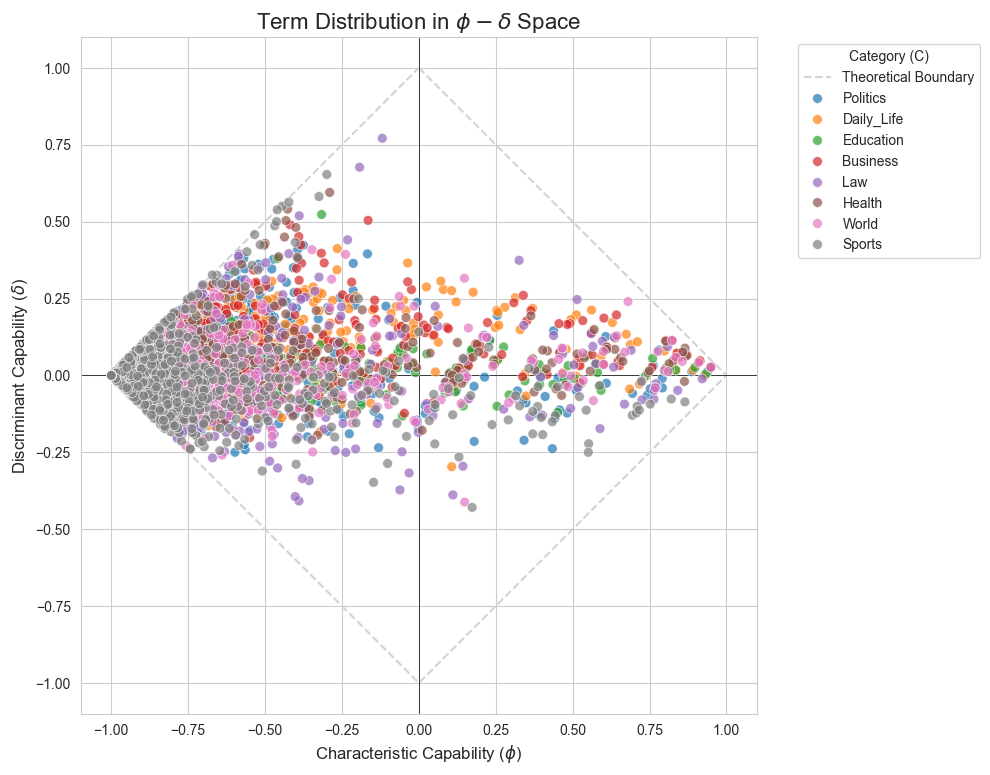

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")


rhombus_x = [0, 1, 0, -1, 0]
rhombus_y = [1, 0, -1, 0, 1]
plt.plot(rhombus_x, rhombus_y, color='lightgray', linestyle='--', zorder=1, label='Theoretical Boundary')



sns.scatterplot(
    data=results_df,
    x='phi',
    y='delta',
    hue='label',  # Color points by their target category
    alpha=0.7,
    s=50,  # Marker size
    zorder=2
)

plt.title(r'Term Distribution in $\phi-\delta$ Space', fontsize=16)
plt.xlabel(r'Characteristic Capability ($\phi$)', fontsize=12)
plt.ylabel(r'Discriminant Capability ($\delta$)', fontsize=12)


# Add center lines
plt.axhline(0, color='black', linewidth=0.5, zorder=1)
plt.axvline(0, color='black', linewidth=0.5, zorder=1)

# Ensure the plot is square
plt.gca().set_aspect('equal', adjustable='box')


plt.legend(title='Category (C)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('plot/task6.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:




# Calculate 'stopword_score'
results_df['abs_delta'] = results_df['delta'].abs()
results_df['stopword_score'] = results_df['phi'] - results_df['abs_delta']

# Filter for potential stopwords (phi > 0)
stopwords_df = results_df[results_df['phi'] > 0]


top_5_per_label = stopwords_df.sort_values(
    by='stopword_score', ascending=False
).groupby('label').head(5).copy()


cols_to_print = ['word', 'phi', 'delta', 'stopword_score']
display_column_created = False

if translator:
    print("Translating top 5 stopwords (word by word)...")
    unique_words = top_5_per_label['word'].unique().tolist()
    translated_list = translate_words(unique_words)
    
    translation_map = dict(zip(unique_words, translated_list))
    top_5_per_label['translation (en)'] = top_5_per_label['word'].map(translation_map)
    
    print("Translation complete.")
    display_column_created = True
else:
    print("Translator not available, skipping translation.")


# Create a rank column (1 to 5) for each label group
top_5_per_label['rank'] = top_5_per_label.groupby('label').cumcount() + 1


if display_column_created:
    print("Formatting with translations...")
    top_5_per_label['display'] = top_5_per_label['word'] + " (" + top_5_per_label['translation (en)'].fillna('N/A') + ")"
else:
    print("Formatting without translations...")
    top_5_per_label['display'] = top_5_per_label['word']


side_by_side_df = top_5_per_label.pivot(
    index='rank', 
    columns='label', 
    values='display'
)

side_by_side_df = side_by_side_df.fillna('') # Replace NaN
side_by_side_df.index.name = 'Rank'

print("\n" + "="*50)
print("Top 5 Plausible Stopwords (Side-by-Side)")
print("="*50)


print(side_by_side_df.to_string())

Translating top 5 stopwords (word by word)...
Translation complete.
Formatting with translations...

Top 5 Plausible Stopwords (Side-by-Side)
label         Business       Daily_Life        Education           Health              Law         Politics           Sports            World
Rank                                                                                                                                         
1             và (and)         và (and)         và (and)         và (and)         và (and)         và (and)         và (and)         và (and)
2      của (belong to)  của (belong to)  của (belong to)  của (belong to)  của (belong to)  của (belong to)  của (belong to)  của (belong to)
3           trong (in)       trong (in)       trong (in)       trong (in)       cho (give)        có (Have)       với (with)       trong (in)
4          được (Okay)      được (Okay)      được (Okay)      được (Okay)        có (Have)       trong (in)       trong (in)      được (Okay)
5     

In [10]:

import pandas as pd


term_scores_df = results_df.groupby('word')[['phi', 'abs_delta', 'stopword_score']].mean().reset_index()

# Sort to find the best stopword candidates
term_scores_df = term_scores_df[term_scores_df['phi'] > 0].sort_values(
    by='stopword_score', ascending=False
)

# Calculate precision at different K values
k_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
precision_results = []

for k in k_values:
    top_k_terms = term_scores_df.head(k)['word'] 
    num_matches = top_k_terms.isin(vietnamese_stopwords_set).sum()
    precision = num_matches / k
    precision_results.append({'k': k, 'precision': precision})

# create a new DataFrame for plotting
precision_df = pd.DataFrame(precision_results)

print("\nGlobal Precision Results (from vn_df):")
print(precision_df)


Global Precision Results (from vn_df):
      k  precision
0     5   1.000000
1    10   1.000000
2    20   1.000000
3    30   1.000000
4    40   1.000000
5    50   0.880000
6    60   0.733333
7    70   0.628571
8    80   0.550000
9    90   0.488889
10  100   0.440000


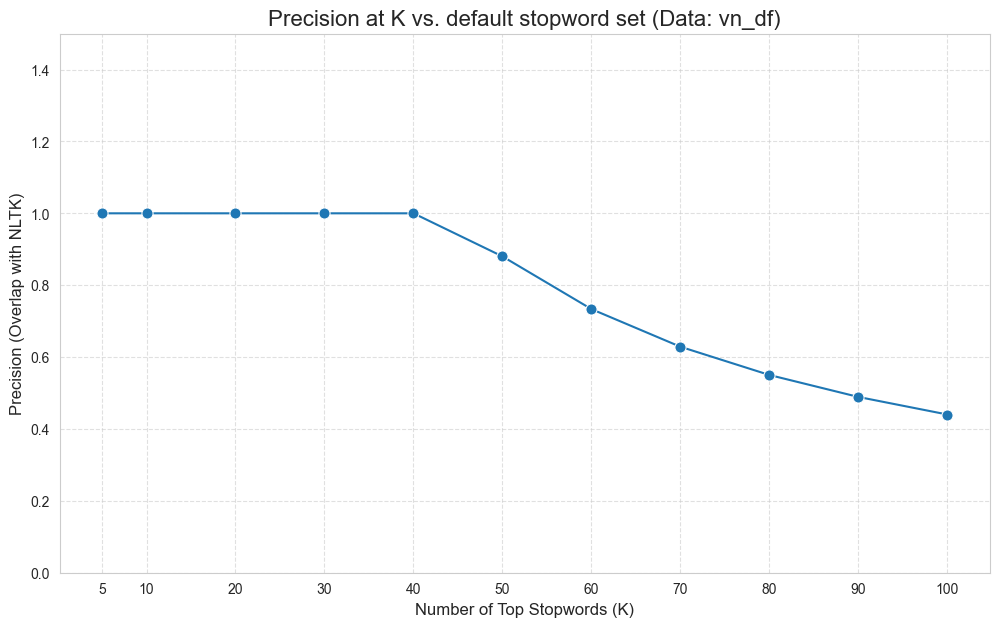

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")


sns.lineplot(
    data=precision_df,
    x='k',
    y='precision',
    marker='o',
    markersize=8
)


plt.title('Precision at K vs. default stopword set (Data: vn_df)', fontsize=16)
plt.xlabel('Number of Top Stopwords (K)', fontsize=12)
plt.ylabel('Precision (Overlap with NLTK)', fontsize=12)
plt.xticks(k_values)
plt.ylim(0, 1.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('plot/task6.png', dpi=300, bbox_inches='tight')


plt.show()

# Question 7: 2D Representation

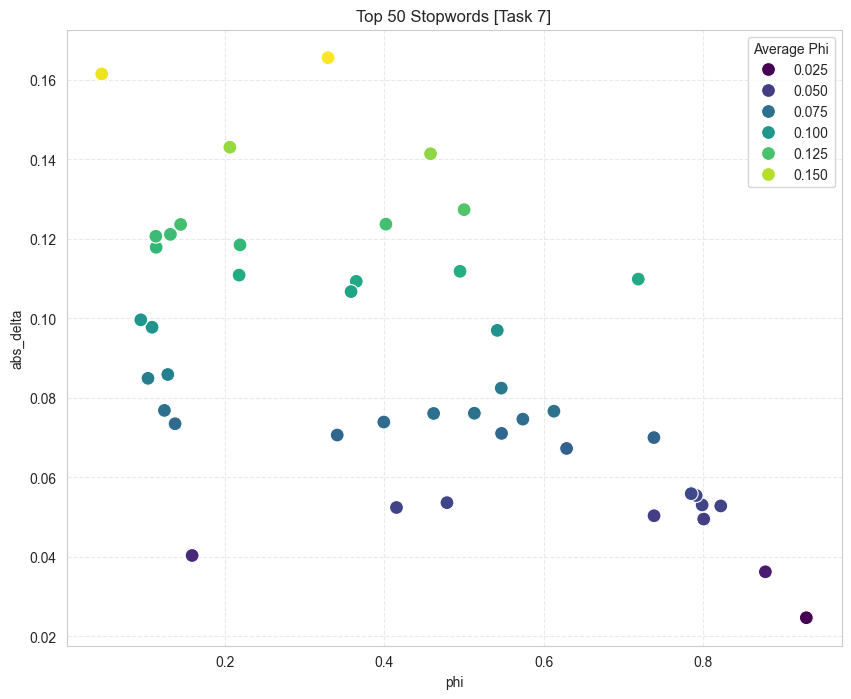

In [12]:
# Select top 50 stopwords based on 6
# loading from pkl file would require another sort

top50_df = term_scores_df.head(50).copy()

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='phi', 
    y='abs_delta', 
    data=top50_df, 
    hue='abs_delta', 
    palette='viridis', 
    s=100
)

plt.title("Top 50 Stopwords [Task 7]")
plt.xlabel("phi")
plt.ylabel("abs_delta")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title="Average Phi", loc='upper right')

plt.savefig('plot/task7.png', dpi=300, bbox_inches='tight')
plt.show()


# Question 8: K-mean algorithm

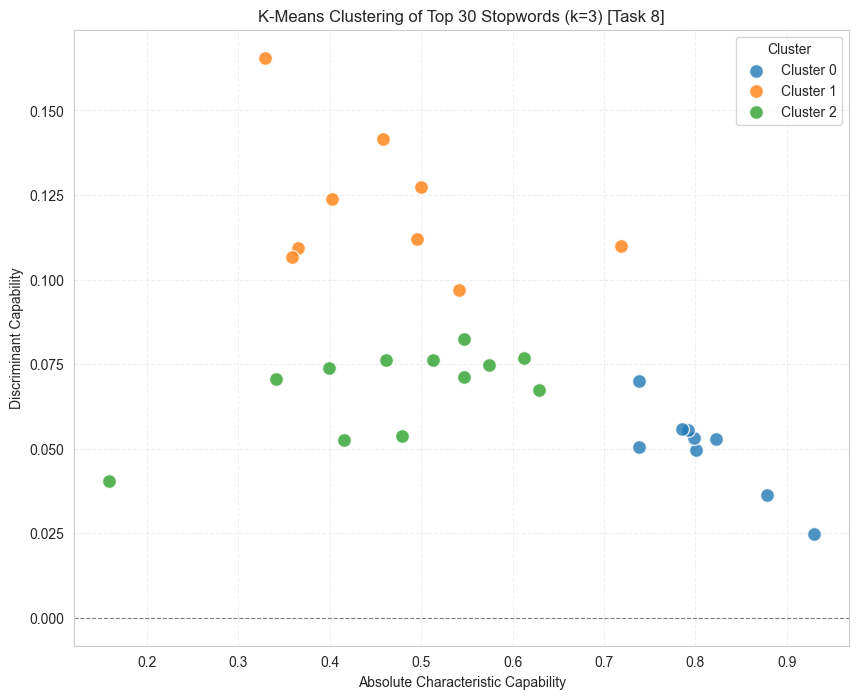

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

TOP_N_CLUSTER = 30
NUM_CLUSTERS = 3  


# Select top 30 stopwords from 6 
top30_cluster_df = term_scores_df.head(TOP_N_CLUSTER).copy()
top30_cluster_df['phi'] = top30_cluster_df['phi'].abs()

# Features for clustering
X = top30_cluster_df[['abs_delta', 'phi']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
top30_cluster_df['cluster'] = kmeans.fit_predict(X_scaled)


# plot
plt.figure(figsize=(10, 8))
for cluster_id in sorted(top30_cluster_df['cluster'].unique()):
    subset = top30_cluster_df[top30_cluster_df['cluster'] == cluster_id]
    plt.scatter(
        subset['phi'],
        subset['abs_delta'],
        s=100,
        label=f"Cluster {cluster_id}",
        alpha=0.8,
        edgecolors='w'
    )


plt.title(f"K-Means Clustering of Top {TOP_N_CLUSTER} Stopwords (k={NUM_CLUSTERS}) [Task 8]")
plt.xlabel("Absolute Characteristic Capability")
plt.ylabel("Discriminant Capability")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title="Cluster")

plt.savefig('plot/task8.png', dpi=300, bbox_inches='tight')
plt.show()



In [14]:

print("\n Cluster Summary (Top 30 Stopwords by Cluster with Translation) [Task 8]")

cluster_ids = sorted(top30_cluster_df['cluster'].unique())

# Loop through each cluster
for cluster_id in cluster_ids:
    print(f"\nCluster {cluster_id}:")
    subset_df = top30_cluster_df[top30_cluster_df['cluster'] == cluster_id].copy() 

    subset_df['translation'] = translate_words(subset_df['word'].tolist())
    print(subset_df[['word', 'translation', 'abs_delta', 'phi', 'cluster']].to_markdown(index=False, floatfmt=".4f"))



 Cluster Summary (Top 30 Stopwords by Cluster with Translation) [Task 8]

Cluster 0:
| word   | translation   |   abs_delta |    phi |   cluster |
|:-------|:--------------|------------:|-------:|----------:|
| và     | and           |      0.0247 | 0.9296 |         0 |
| của    | belong to     |      0.0362 | 0.8782 |         0 |
| trong  | in            |      0.0528 | 0.8223 |         0 |
| được   | Okay          |      0.0495 | 0.8009 |         0 |
| có     | Have          |      0.0531 | 0.7989 |         0 |
| cho    | give          |      0.0554 | 0.7914 |         0 |
| là     | To be         |      0.0559 | 0.7851 |         0 |
| với    | with          |      0.0504 | 0.7385 |         0 |
| đã     | Satisfied     |      0.0700 | 0.7384 |         0 |

Cluster 1:
| word   | translation   |   abs_delta |    phi |   cluster |
|:-------|:--------------|------------:|-------:|----------:|
| các    | the           |      0.1099 | 0.7188 |         1 |
| người  | People        |      0.

# Question 9: Using default stopword set

Scaling features and running K-Means...
Clustering complete.
Plotting clusters for Task 9...


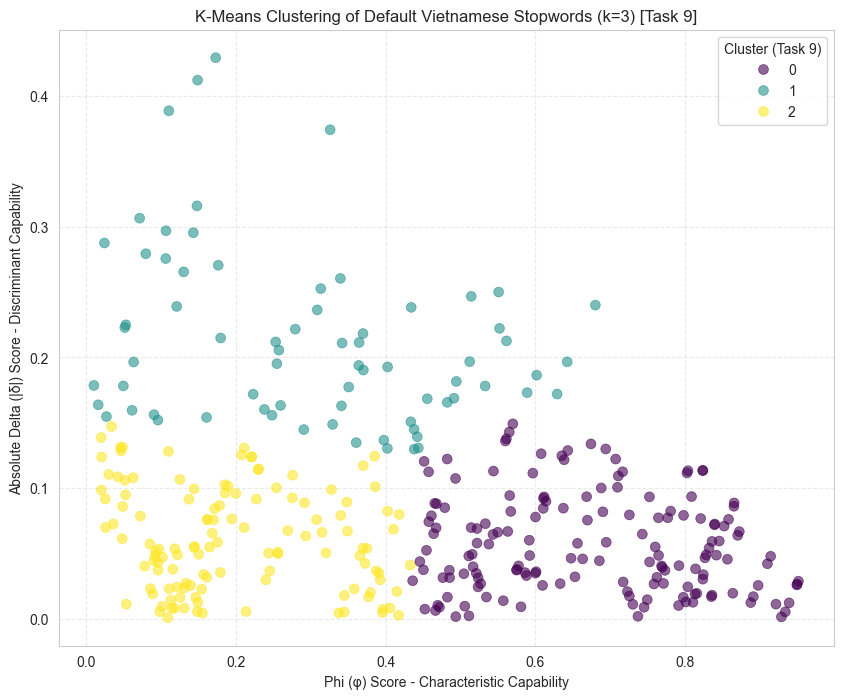

In [15]:

ranked_words_df = stopwords_df

# Get default stopwords present in corpus

corpus_words_set = set(ranked_words_df['word'])
default_stopwords_in_corpus = [word for word in vietnamese_stopwords_set if word in corpus_words_set]

if len(default_stopwords_in_corpus) == 0:
    raise ValueError("No default Vietnamese stopwords were found in the corpus results from Task 6.")


# Filter ranked_words_df to get only the rows for default stopwords
default_stopwords_cluster_df = ranked_words_df[ranked_words_df['word'].isin(default_stopwords_in_corpus)].copy()


print("Scaling features and running K-Means...")
# Select features for clustering
X_default = default_stopwords_cluster_df[['phi', 'abs_delta']].values

# Scale features
scaler_default = StandardScaler() # Assumes StandardScaler is imported
X_default_scaled = scaler_default.fit_transform(X_default)
# Apply K-Means
kmeans_default = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10) 
default_stopwords_cluster_df['cluster'] = kmeans_default.fit_predict(X_default_scaled)
print("Clustering complete.")


print("Plotting clusters for Task 9...")
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=default_stopwords_cluster_df,
    x='phi', 
    y='abs_delta', 
    hue='cluster',
    palette='viridis', 
    s=50, alpha=0.6, edgecolor=None 
)

plt.title(f"K-Means Clustering of Default Vietnamese Stopwords (k={NUM_CLUSTERS}) [Task 9]")
plt.xlabel("Phi (φ) Score - Characteristic Capability") 
plt.ylabel("Absolute Delta (|δ|) Score - Discriminant Capability") 
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title="Cluster (Task 9)")
plt.savefig(os.path.join('plot','task9.png'), dpi=300, bbox_inches='tight') 
plt.show()



In [16]:


print("\n Cluster Summary (Default Stopwords by Cluster with Translation) [Task 9] ")
cluster_ids_task9 = sorted(default_stopwords_cluster_df['cluster'].unique())
    
# Loop through each cluster
for cluster_id in cluster_ids_task9:
    print(f"\nCluster {cluster_id}:")
    
    # only do 10 because there's a lot
    subset_df_task9 = default_stopwords_cluster_df[default_stopwords_cluster_df['cluster'] == cluster_id].head(10).copy() 
    subset_df_task9['translation'] = translate_words(subset_df_task9['word'].tolist())
    print(subset_df_task9[['word', 'translation', 'delta', 'phi', 'cluster']].to_markdown(index=False, floatfmt=".4f"))



 Cluster Summary (Default Stopwords by Cluster with Translation) [Task 9] 

Cluster 0:
| word   | translation   |   delta |    phi |   cluster |
|:-------|:--------------|--------:|-------:|----------:|
| cho    | give          | -0.0648 | 0.7428 |         0 |
| các    | the           |  0.0824 | 0.7806 |         0 |
| có     | Have          | -0.0102 | 0.7912 |         0 |
| của    | belong to     |  0.0124 | 0.8876 |         0 |
| không  | Are not       | -0.1222 | 0.4822 |         0 |
| là     | To be         | -0.0435 | 0.7525 |         0 |
| người  | People        | -0.1124 | 0.4574 |         0 |
| theo   | according to  | -0.0166 | 0.4826 |         0 |
| trong  | in            | -0.0407 | 0.7917 |         0 |
| và     | and           |  0.0122 | 0.9388 |         0 |

Cluster 1:
| word   | translation   |   delta |    phi |   cluster |
|:-------|:--------------|--------:|-------:|----------:|
| khi    | When          | -0.2382 | 0.4342 |         1 |
| một    | one           | -0.

# Question 10: W2V model

### Comparing the Armano's stopwords

Loading cached Task 10 results from pkl_folder\task10_top30_armano.pkl...
Results loaded.


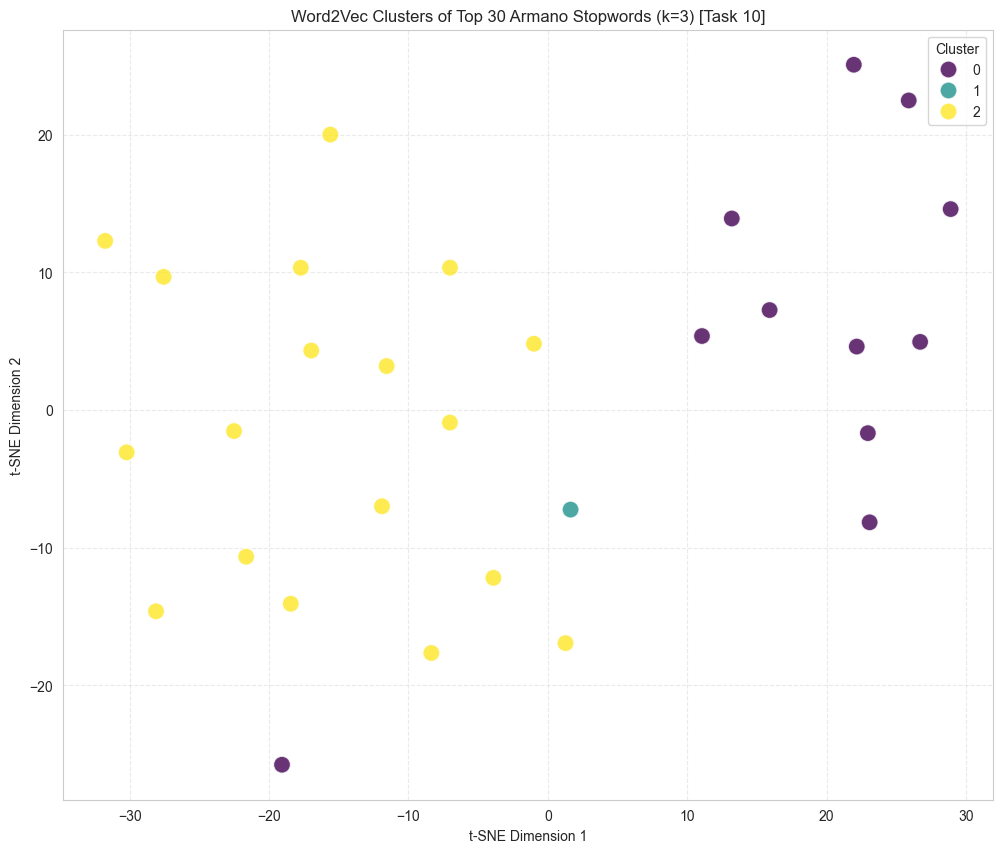

In [17]:
TASK10_TOP30_PKL = os.path.join(PKL_FOLDER, 'task10_top30_armano.pkl') 
NUM_CLUSTERS = 3 

if os.path.exists(TASK10_TOP30_PKL):
    print(f"Loading cached Task 10 results from {TASK10_TOP30_PKL}...")
    with open(TASK10_TOP30_PKL, 'rb') as f:
        cluster_summary = pickle.load(f)
        X_tsne = pickle.load(f)
    print("Results loaded.")

else:
    top_terms = top30_cluster_df['word'].tolist()

    X_w2v = []
    valid_terms = []

    print("Extracting Word2Vec embeddings for Top 30 Armano stopwords...")
    for term in tqdm(top_terms, desc="Embedding extraction (Top 30)"):
        if term in w2v_model:       
            X_w2v.append(w2v_model[term])
            valid_terms.append(term)

    X_w2v = np.array(X_w2v)
    print(f"Found embeddings for {len(valid_terms)} / {len(top_terms)} words.")

    if len(valid_terms) == 0:
        raise ValueError("No embeddings found for the top 30 words. Cannot proceed.")

    # Cluster on embeddings
    print(f"Running K-Means clustering on embeddings (k={NUM_CLUSTERS})...")
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=12, n_init=10)
    clusters = kmeans.fit_predict(X_w2v)
    print("Clustering completed.")


    print("Running t-SNE for visualization...")
    perplexity_val_top30 = min(5, len(valid_terms) - 1)
    if perplexity_val_top30 < 1:
        perplexity_val_top30 = 1

    tsne = TSNE(
        n_components=2,
        random_state=1,
        perplexity=perplexity_val_top30,
        init='pca'
    )
    X_tsne = tsne.fit_transform(X_w2v)
    print("t-SNE completed.")

    # Combine results
    cluster_summary = pd.DataFrame({
        "word": valid_terms,
        "tsne_1": X_tsne[:, 0],
        "tsne_2": X_tsne[:, 1],
        "cluster": clusters
    })

    # Save results
    print(f"Saving Task 10 (Top 30) results to {TASK10_TOP30_PKL}...")
    with open(TASK10_TOP30_PKL, 'wb') as f:
        pickle.dump(cluster_summary, f)
        pickle.dump(X_tsne, f)
    print("Results saved.")

# plot
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='viridis',
    s=150, alpha=0.8, edgecolor='w'
)


plt.title(f"Word2Vec Clusters of Top 30 Armano Stopwords (k={NUM_CLUSTERS}) [Task 10]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig('plot/task10_top30_armano.png', dpi=300, bbox_inches='tight')
plt.show()


Loading cached Task 10 (Default) results from pkl_folder\task10_default.pkl...
Results loaded.


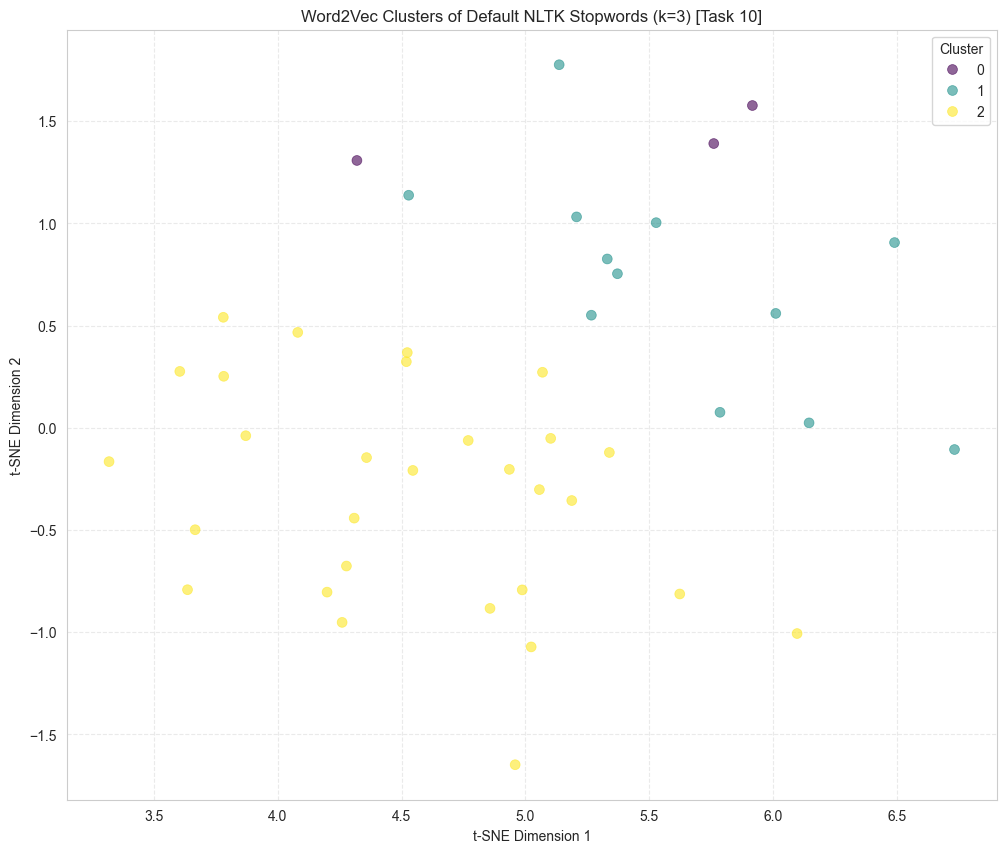

In [18]:
TASK10_DEFAULT_PKL = os.path.join(PKL_FOLDER, 'task10_default.pkl') 

if os.path.exists(TASK10_DEFAULT_PKL):
    print(f"Loading cached Task 10 (Default) results from {TASK10_DEFAULT_PKL}...")
    with open(TASK10_DEFAULT_PKL, 'rb') as f:
        cluster_summary_default = pickle.load(f)
        X_tsne_default = pickle.load(f)
    print("Results loaded.")

else:
    print("Cache not found for Task 10 (Default). Running analysis...")
    
    default_terms = default_stopwords_cluster_df['word'].tolist() 

    X_w2v_default = []      
    valid_terms_default = [] 

    print("Extracting Word2Vec embeddings for default stopwords (present in corpus)...")
    for term in tqdm(default_terms, desc="Embedding extraction (Default)"):
        if term in w2v_model:  
            X_w2v_default.append(w2v_model[term])
            valid_terms_default.append(term)

    X_w2v_default = np.array(X_w2v_default)
    print(f"Found embeddings for {len(valid_terms_default)} / {len(default_terms)} words.")

    if len(valid_terms_default) == 0:
         raise ValueError("No embeddings found for the default stopwords. Cannot proceed.")

    # Cluster on embeddings
    print(f"Running K-Means clustering on embeddings (k={NUM_CLUSTERS}) for default stopwords...")
    kmeans_default = KMeans(n_clusters=NUM_CLUSTERS, random_state=1, n_init=10)
    clusters_default = kmeans_default.fit_predict(X_w2v_default)
    print("Clustering completed.")

    print("Running t-SNE for visualization...")
    perplexity_val = min(30, len(valid_terms_default) - 1)
    if perplexity_val < 1:
        perplexity_val = 1

    tsne_default = TSNE(
        n_components=2,
        random_state=1,
        perplexity=perplexity_val,
        init='pca'
    )
    X_tsne_default = tsne_default.fit_transform(X_w2v_default)
    print("t-SNE completed.")

    cluster_summary_default = pd.DataFrame({
        "word": valid_terms_default,
        "tsne_1": X_tsne_default[:, 0],
        "tsne_2": X_tsne_default[:, 1],
        "cluster": clusters_default
    })


    print(f"Saving Task 10 (Default) results to {TASK10_DEFAULT_PKL}...")
    with open(TASK10_DEFAULT_PKL, 'wb') as f:
        pickle.dump(cluster_summary_default, f)
        pickle.dump(X_tsne_default, f)
    print("Results saved.")


plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary_default,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='viridis', 
    s=50, alpha=0.6, edgecolor=None
)

plt.title(f"Word2Vec Clusters of Default NLTK Stopwords (k={NUM_CLUSTERS}) [Task 10]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig(os.path.join('plot','task10_default.png'), dpi=300, bbox_inches='tight')
plt.show()


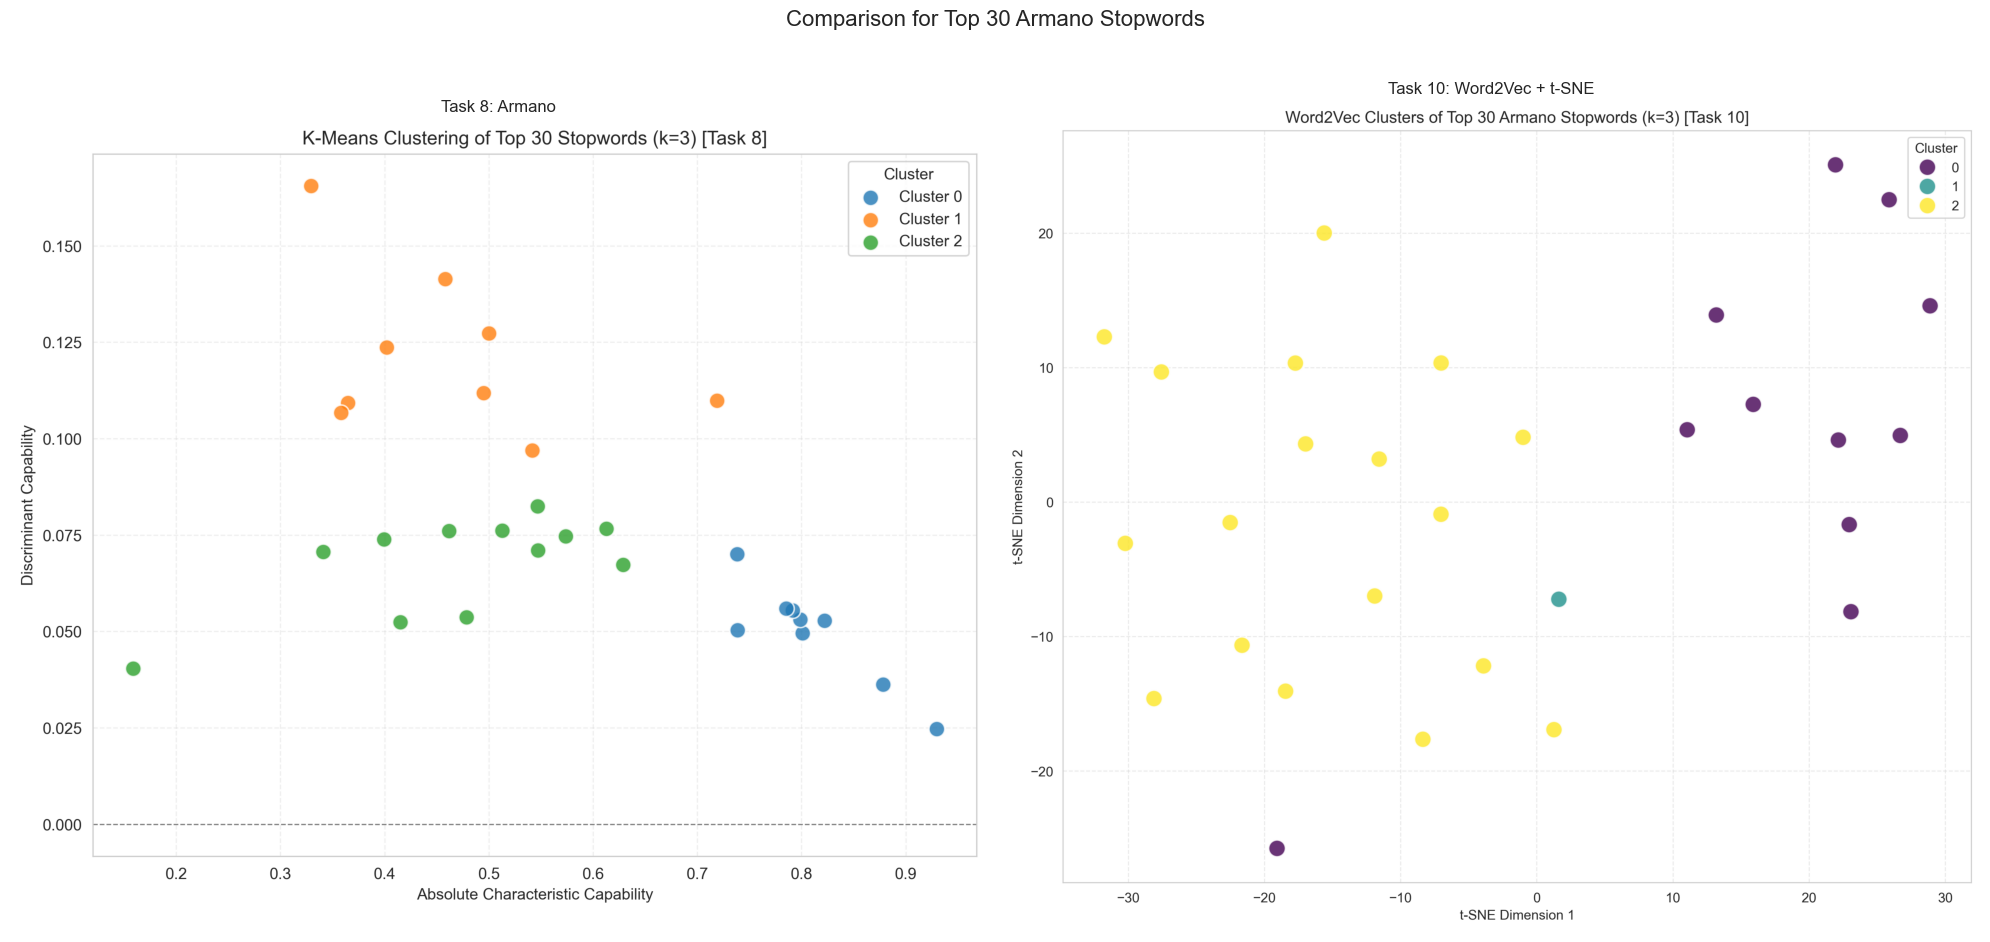

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


# Comparison for Top 30 Armano Stopwords 


task8_img_path = 'plot/task8.png'
task10_top30_img_path = 'plot/task10_top30_armano.png'

task9_img_path = os.path.join('plot/task9.png')
task10_default_img_path = os.path.join('plot/task10_default.png')

fig1, axes1 = plt.subplots(1, 2, figsize=(20, 10))
img8 = mpimg.imread(task8_img_path)
axes1[0].imshow(img8)
axes1[0].set_title('Task 8: Armano')
axes1[0].axis('off') 
img10_top30 = mpimg.imread(task10_top30_img_path)
axes1[1].imshow(img10_top30)
axes1[1].set_title('Task 10: Word2Vec + t-SNE')
axes1[1].axis('off')

fig1.suptitle('Comparison for Top 30 Armano Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




In [20]:
print("Creating merged DataFrame with cluster assignments...")


task8_clusters_to_merge = top30_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task8'}
)
task10_clusters_to_merge = cluster_summary[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task10'}
)

# Use outer merge in case some words were missing embeddings in Task 10
merged_clusters = pd.merge(
    task8_clusters_to_merge,
    task10_clusters_to_merge,
    on='word',
    how='outer' # Keep all words from both analyses
)

merged_clusters['Translation'] = translate_words(merged_clusters['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task8', 'cluster_task10']

print("\n==== Merged Cluster Assignments (Task 8 vs Task 10) ====")
print("      (Top 30 Armano Stopwords)")
print(merged_clusters[display_cols].sort_values(by=['cluster_task8', 'cluster_task10']).to_markdown(index=False, floatfmt=".0f"))


Creating merged DataFrame with cluster assignments...

==== Merged Cluster Assignments (Task 8 vs Task 10) ====
      (Top 30 Armano Stopwords)
| word   | Translation   |   cluster_task8 |   cluster_task10 |
|:-------|:--------------|----------------:|-----------------:|
| đã     | Satisfied     |               0 |                0 |
| cho    | give          |               0 |                2 |
| có     | Have          |               0 |                2 |
| của    | belong to     |               0 |                2 |
| là     | To be         |               0 |                2 |
| trong  | in            |               0 |                2 |
| và     | and           |               0 |                2 |
| với    | with          |               0 |                2 |
| được   | Okay          |               0 |                2 |
| người  | People        |               1 |                0 |
| tại    | in            |               1 |                0 |
| đến    | arrive       

## Findings:


1.  **Significant Divergence:** There is very little direct correspondence between the clusters formed in Task 8 and Task 10. Words grouped together based on similar statistical distribution are often placed in different clusters based on semantic similarity (Word2Vec/t-SNE), and vice-versa.
   
2.  **Task 8 Clustering (Armano):**
    * Cluster 0 contains words with relatively lower characteristic scores among this top 30 group.
    * Cluster 1 contains words with intermediate characteristic scores.
    * Cluster 2 contains words with the highest characteristic scores (closest to 1) and generally lower discriminant scores, best fitting the Armano criteria. The words here (`cho`, `có`, `của`, `là`, `trong`, `và`, `với`, `được`) are common Vietnamese function words (similar to article, prepositions, conjunctions, etc.), despite being ranked lower than rare words by the Armano method overall (as seen in Task 6). Within this *specific* top 30 list selected by the criteria, these function words have the most "stopword-like" statistical profile.
  
3.  **Task 10 Clustering (Word2Vec/t-SNE):**
    * The semantic clusters group words differently.
    * Cluster 0 (Task 10) gathers many high-frequency function words (`các`, `không`, `này`, `trên`, `về`, `đó`, `để`, `cũng`, `một`, `nhiều`, `những`, `theo`, `cho`, `có`, `của`, `là`, `trong`, `và`, `với`, `được`), suggesting they share similar contexts in the Word2Vec training data.
  
    * Cluster 1 (Task 10) contains only one word (`người` - person/people).
    * Cluster 2 (Task 10) groups prepositions/adverbs related to time or sequence (`khi`, `ra`, `sau`, `từ`, `vào`) along with `ngày` (day), `tại` (at/in), `đến` (arrive/to), and `đã` (already/past tense marker).
  
4.  **Mismatch Examples:**
    * Common words like `và` (and), `của` (of), `là` (is/to be), `có` (have), `cho` (give/for), `trong` (in), `với` (with), `được` (can/get/ok) all fall into Task 8's Cluster 2, but they all fall into Task 10's Cluster 0 
  
    * Words like `khi` (when), `ra` (out/go out), `sau` (after), `từ` (from), `vào` (in/enter) are spread across Task 8's Clusters 0 and 1, but form a distinct semantic group in Task 10's Cluster 2.

**Interpretation:**

* Clustering based on **corpus-specific statistical distribution (Task 8)** doesn't align well with clustering based on **general semantic context (Task 10)** for this set of words.

* Task 8 primarily separates words based on how evenly they are spread across *specific news categories*.
  
* Task 10 primarily separates words based on their learned meaning and grammatical function from a large, general text corpus (used to train Word2Vec).

* In conlussion, grouping the Top 30 Armano stopwords based on their statistical distribution in this news corpus (Task 8) results in different clusters than grouping them based on their general semantic meaning captured by Word2Vec (Task 10). 
  
* This means words that behave similarly statistically within this specific dataset (e.g., being equally spread out or rare) don't necessarily have similar meanings or grammatical functions according to the broader language context learned by Word2Vec. The statistical clustering (Task 8) reflects the words' roles in distinguishing the news categories, while the semantic clustering (Task 10) reflects their general linguistic relationships.

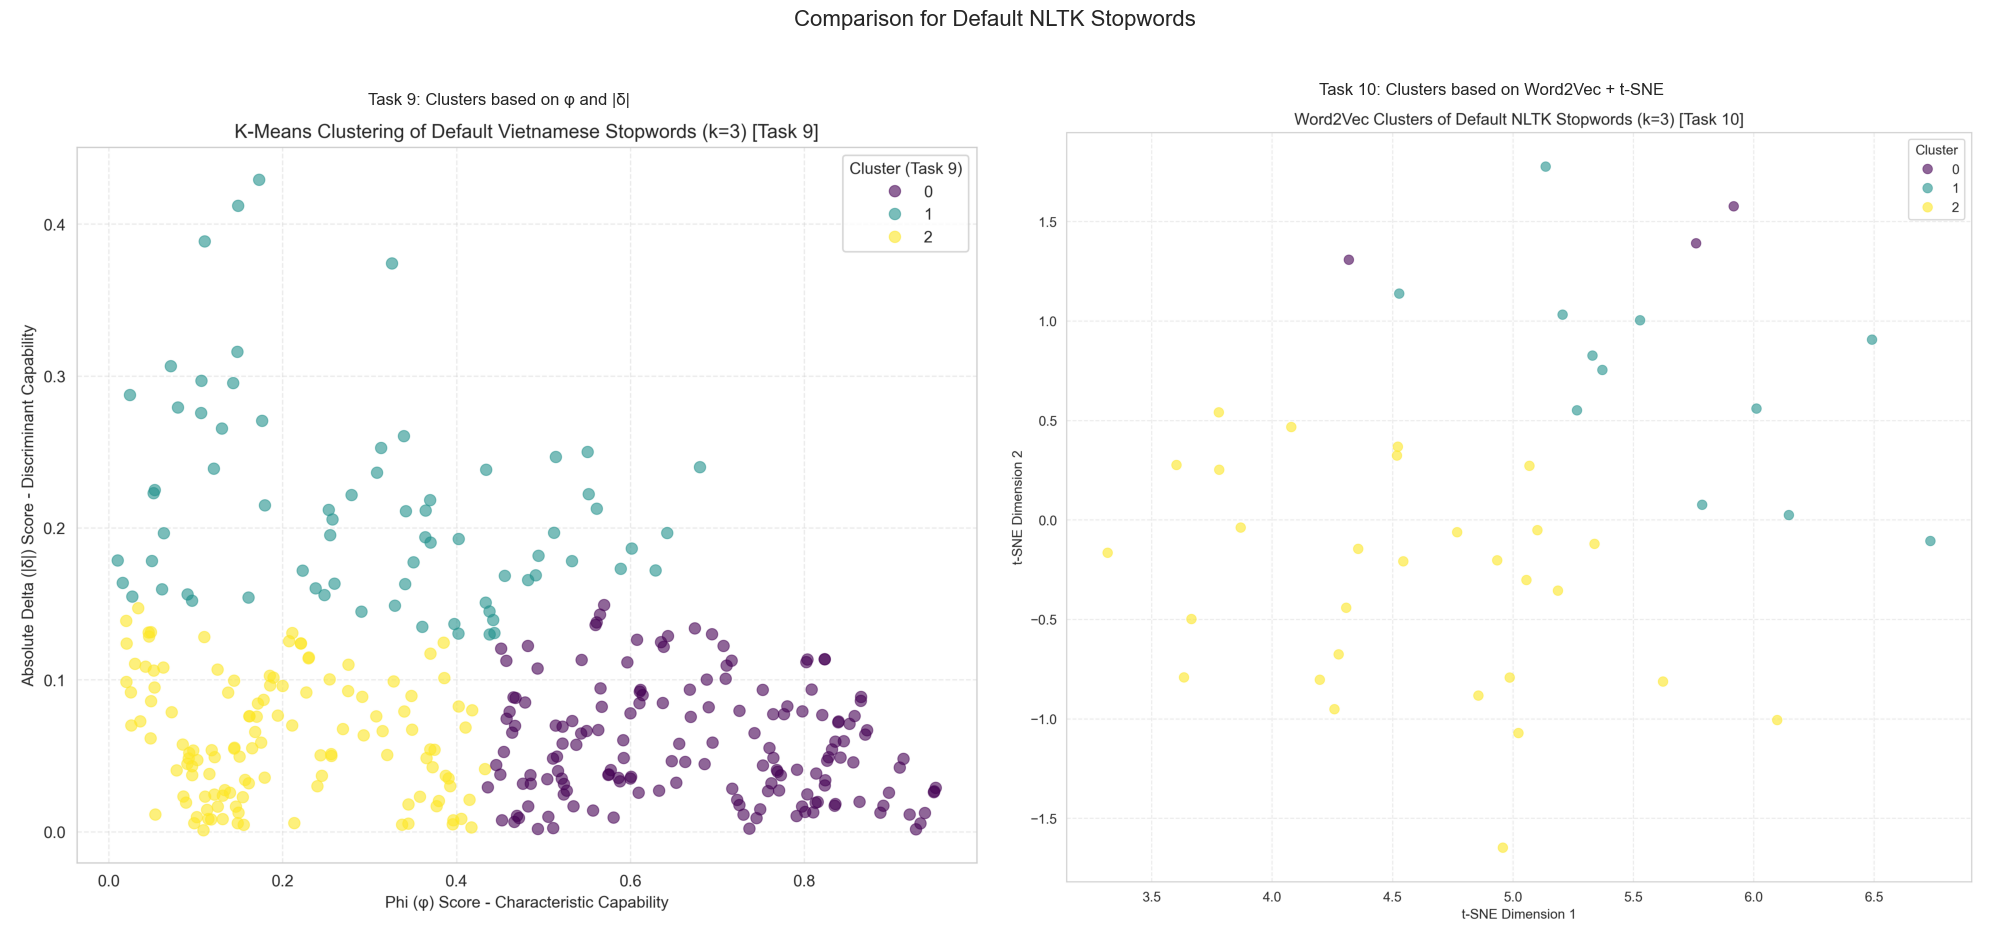

In [21]:

# Comparison for Default NLTK Stopwords 
fig2, axes2 = plt.subplots(1, 2, figsize=(20, 10))

img9 = mpimg.imread(task9_img_path)
axes2[0].imshow(img9)
axes2[0].set_title('Task 9: Clusters based on φ and |δ|')
axes2[0].axis('off')

img10_default = mpimg.imread(task10_default_img_path)
axes2[1].imshow(img10_default)
axes2[1].set_title('Task 10: Clusters based on Word2Vec + t-SNE')
axes2[1].axis('off')
fig2.suptitle('Comparison for Default NLTK Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [22]:


print("Merging Task 9 and Task 10 cluster assignments for common words...")


task9_data_full = default_stopwords_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task9'}
)
task10_data_full = cluster_summary_default[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task10'}
)

# use "inner" because there are a lot 
merged_common_words = pd.merge(
    task9_data_full,
    task10_data_full,
    on='word',
    how='inner' # Keep only words that appear in both dataframes
)

# Check if enough common words exist
num_common = len(merged_common_words)
sample_size = min(30, num_common) # Take 30 or fewer if less than 30 common words

if num_common < 30:
    print(f"Warning: Only {num_common} words were found in both Task 9 and Task 10 results. Sampling {num_common} words.")
else:
    print(f"Found {num_common} common words. Sampling 30...")


merged_clusters_sample = merged_common_words.sample(n=sample_size, random_state=2)


print("Adding translations...")
merged_clusters_sample['Translation'] = translate_words(merged_clusters_sample['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task9', 'cluster_task10']




print(f"\n--- Random Sample of {sample_size} Common Words: Cluster Assignments (Task 9 vs Task 10) ---")
# Sort for potentially clearer viewing
print(merged_clusters_sample[display_cols].sort_values(by=['cluster_task9', 'cluster_task10']).to_markdown(index=False, floatfmt=".0f"))

Merging Task 9 and Task 10 cluster assignments for common words...
Found 336 common words. Sampling 30...
Adding translations...

--- Random Sample of 30 Common Words: Cluster Assignments (Task 9 vs Task 10) ---
| word   | Translation   |   cluster_task9 |   cluster_task10 |
|:-------|:--------------|----------------:|-----------------:|
| khi    | When          |               0 |                1 |
| đến    | arrive        |               0 |                1 |
| và     | and           |               0 |                2 |
| của    | belong to     |               0 |                2 |
| một    | one           |               0 |                2 |
| những  | these         |               0 |                2 |
| theo   | according to  |               0 |                2 |
| có     | Have          |               0 |                2 |
| không  | Are not       |               0 |                2 |
| với    | with          |               0 |                2 |
| trên   | above    

### Findings

1.  **Divergence in Groupings:** As seen with the Armano words, the clustering results differ significantly between the two methods. A word's cluster assignment based on its statistical distribution (Task 9) often does not match its cluster based on semantic similarity (Task 10).

2.  **Task 9 Clusters (φ/δ):**
    * The sample includes words from all three Task 9 clusters. Words like `veo`, `nhỉ`, `tà` (Cluster 0) stays on the bottom-right and on the left plot. Words like `chị`, `ngồi`, `nhanh` (Cluster 1) have intermediate scores. Words like `nhưng`, `theo`, `sự` (Cluster 2) is the most likely to be identified as **stopwords**
  
3.  **Task 10 Clusters (Word2Vec/t-SNE):**
    * The semantic clusters group these default stopwords differently. Cluster 0 (Task 10, purple in the right plot) seems to contain a mix of words. Cluster 1 (teal) and Cluster 2 (yellow) also contain words spread across the Task 9 clusters.
  
4.  **Mismatch Examples (from Sample Table):**
    * Words in Task 9 Cluster 0 are split across all three semantic clusters in Task 10 (e.g., `veo` -> 0, `chi` -> 1, `ngăn` -> 2).
  
    * Words in Task 9 Cluster 1 are also split across Task 10 clusters (e.g., `chị` -> 0, `chuyện` -> 1, `tất_cả` -> 2).
  
    * Words in Task 9 Cluster 2 mostly end up in Task 10 Cluster 2, but not exclusively (e.g., `qua`, `nhưng`, `theo`, `sự` are Task 9=2, Task 10=2).
  
5.  **Semantic Coherence (Task 10):** While harder to judge from just a sample, the Task 10 clusters (right plot) likely group words with related grammatical functions or meanings (e.g., perhaps Cluster 2 contains more conjunctions/prepositions, while others contain pronouns/adverbs), whereas Task 9 groups them purely by their statistical footprint in *specific news dataset*.

**Interpretation:**

Similar to the Armano words, clustering default stopwords using corpus-specific statistical distribution (Task 9) yields different results than using general semantic context (Task 10). Many words that behave similarly statistically (e.g., high phi, low absolute delta) may have different semantic roles, and vice-versa. This reinforces that the two methods capture different aspects of word behavior – one context-specific statistical, the other general semantic. Task 10 likely provides more intuitive groupings based on word meaning and usage.

# Question 11: FastText & PPMI (Alternative for Glove)

Loading cached Task 11 (Top 30) results from pkl_folder\task11_top30_armano.pkl...
Results loaded.


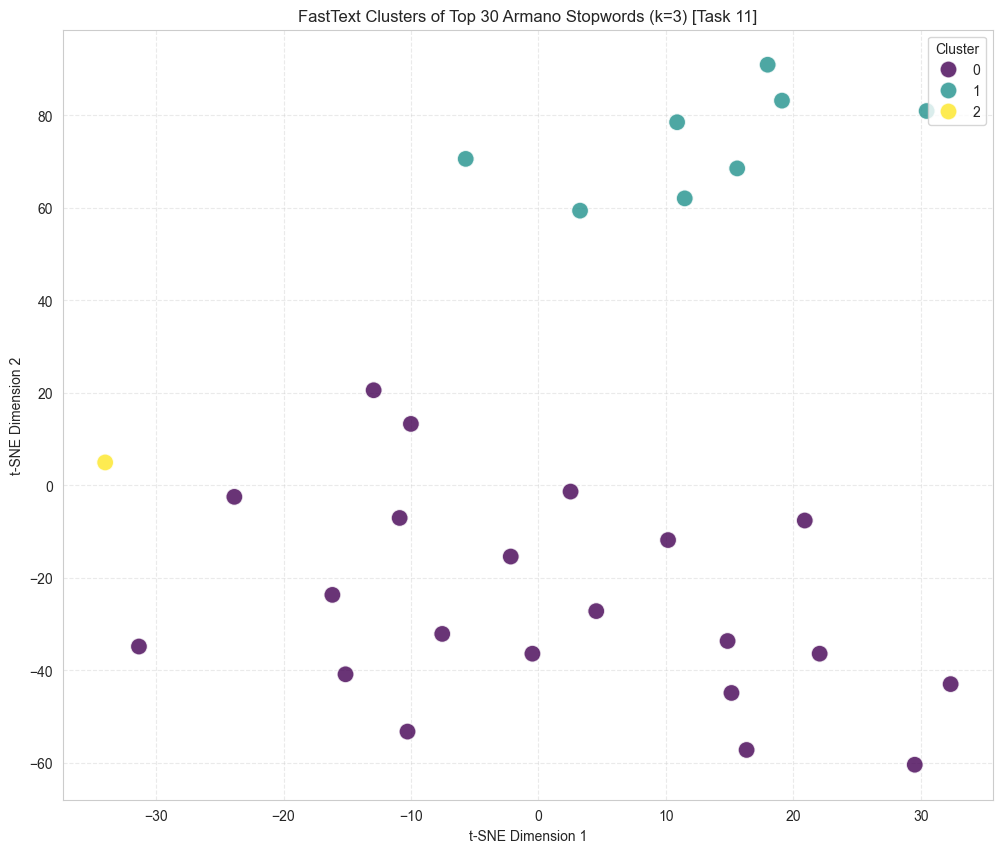

In [23]:

NUM_CLUSTERS = 3

TASK11_TOP30_PKL = os.path.join(PKL_FOLDER, 'task11_top30_armano.pkl')

if os.path.exists(TASK11_TOP30_PKL):
    print(f"Loading cached Task 11 (Top 30) results from {TASK11_TOP30_PKL}...")
    with open(TASK11_TOP30_PKL, 'rb') as f:
        cluster_summary_ft_top30 = pickle.load(f)
        X_tsne_ft_top30 = pickle.load(f)
    print("Results loaded.")

else:
    print("Cache not found for Task 11 (Top 30). Running analysis...")

    top_terms = top30_cluster_df['word'].tolist()

    X_ft_top30 = []
    valid_terms_ft_top30 = []

    print("Extracting FastText embeddings for Top 30 Armano stopwords...")
    for term in tqdm(top_terms, desc="Embedding extraction (FastText, Top 30)"):
        if term in model_ft:
            X_ft_top30.append(model_ft[term])
            valid_terms_ft_top30.append(term)

    X_ft_top30 = np.array(X_ft_top30)
    print(f"Found embeddings for {len(valid_terms_ft_top30)} / {len(top_terms)} words.")
    if len(valid_terms_ft_top30) == 0:
        raise ValueError("No embeddings found for Top 30 stopwords.")

    # Cluster on embeddings
    print(f"Running K-Means clustering (k={NUM_CLUSTERS}) on FastText embeddings...")
    kmeans_ft_top30 = KMeans(n_clusters=NUM_CLUSTERS, random_state=23, n_init=10)
    clusters_ft_top30 = kmeans_ft_top30.fit_predict(X_ft_top30)
    print("Clustering completed.")


    print("Running t-SNE...")
    perplexity_val = min(5, len(valid_terms_ft_top30) - 1)
    if perplexity_val < 1: perplexity_val = 1

    tsne_ft_top30 = TSNE(
        n_components=2,
        random_state=1,
        perplexity=perplexity_val,
        init='pca'
    )
    X_tsne_ft_top30 = tsne_ft_top30.fit_transform(X_ft_top30)
    print("t-SNE completed.")

    cluster_summary_ft_top30 = pd.DataFrame({
        "word": valid_terms_ft_top30,
        "tsne_1": X_tsne_ft_top30[:, 0],
        "tsne_2": X_tsne_ft_top30[:, 1],
        "cluster": clusters_ft_top30
    })

    print(f"Saving Task 11 (Top 30) results to {TASK11_TOP30_PKL}...")
    with open(TASK11_TOP30_PKL, 'wb') as f:
        pickle.dump(cluster_summary_ft_top30, f)
        pickle.dump(X_tsne_ft_top30, f)
    print("Results saved.")

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary_ft_top30,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='viridis',
    s=150, alpha=0.8, edgecolor='w'
)


plt.title(f"FastText Clusters of Top 30 Armano Stopwords (k={NUM_CLUSTERS}) [Task 11]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig(os.path.join('plot','task11_fastText_top30.png'), dpi=300, bbox_inches='tight')
plt.show()



Loading cached Task 11 (Default) results from pkl_folder\task11_default.pkl...
Results loaded.


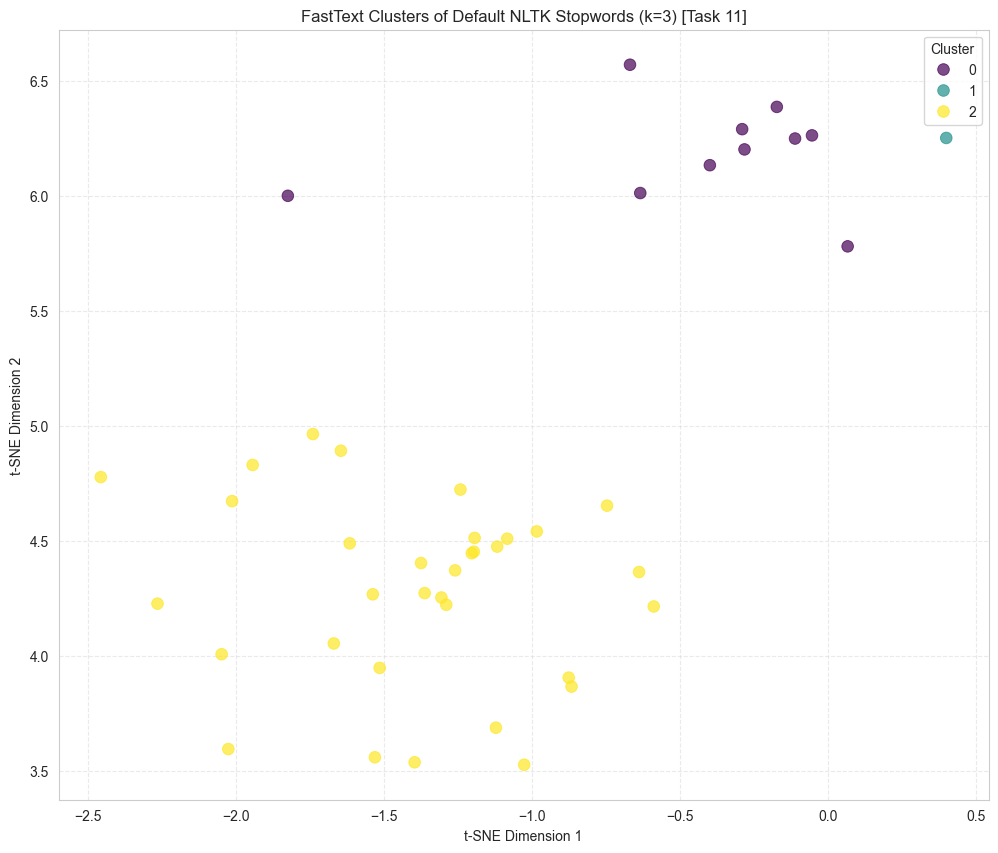

In [24]:

TASK11_DEFAULT_PKL = os.path.join(PKL_FOLDER, 'task11_default.pkl')

if os.path.exists(TASK11_DEFAULT_PKL):
    print(f"Loading cached Task 11 (Default) results from {TASK11_DEFAULT_PKL}...")
    with open(TASK11_DEFAULT_PKL, 'rb') as f:
        cluster_summary_ft_default = pickle.load(f)
        X_tsne_ft_default = pickle.load(f)
    print("Results loaded.")

else:
    print("Cache not found for Task 11 (Default). Running analysis...")

    default_terms = default_stopwords_cluster_df['word'].tolist()

    X_ft_default = []
    valid_terms_ft_default = []

    print("Extracting FastText embeddings for Default stopwords...")
    for term in tqdm(default_terms, desc="Embedding extraction (FastText, Default)"):
        if term in model_ft:
            X_ft_default.append(model_ft[term])
            valid_terms_ft_default.append(term)

    X_ft_default = np.array(X_ft_default)
    print(f"Found embeddings for {len(valid_terms_ft_default)} / {len(default_terms)} words.")
    if len(valid_terms_ft_default) == 0:
        raise ValueError("No embeddings found for Default stopwords.")

    # Cluster on embeddings
    print(f"Running K-Means clustering (k={NUM_CLUSTERS}) on FastText embeddings (Default)...")
    kmeans_ft_default = KMeans(n_clusters=NUM_CLUSTERS, random_state=1, n_init=10)
    clusters_ft_default = kmeans_ft_default.fit_predict(X_ft_default)
    print("Clustering completed.")

    print("Running t-SNE...")
    perplexity_val_default = min(30, len(valid_terms_ft_default) - 1)
    if perplexity_val_default < 1:
        perplexity_val_default = 1

    tsne_ft_default = TSNE(
        n_components=2,
        random_state=1,
        perplexity=perplexity_val_default,
        init='pca'
    )
    X_tsne_ft_default = tsne_ft_default.fit_transform(X_ft_default)
    print("t-SNE completed.")

    cluster_summary_ft_default = pd.DataFrame({
        "word": valid_terms_ft_default,
        "tsne_1": X_tsne_ft_default[:, 0],
        "tsne_2": X_tsne_ft_default[:, 1],
        "cluster": clusters_ft_default
    })


    print(f"Saving Task 11 (Default) results to {TASK11_DEFAULT_PKL}...")
    with open(TASK11_DEFAULT_PKL, 'wb') as f:
        pickle.dump(cluster_summary_ft_default, f)
        pickle.dump(X_tsne_ft_default, f)
    print("Results saved.")

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary_ft_default,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='viridis',
    s=70, alpha=0.7, edgecolor=None
)


plt.title(f"FastText Clusters of Default NLTK Stopwords (k={NUM_CLUSTERS}) [Task 11]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig(os.path.join('plot','task11_fastText_default.png'), dpi=300, bbox_inches='tight')
plt.show()


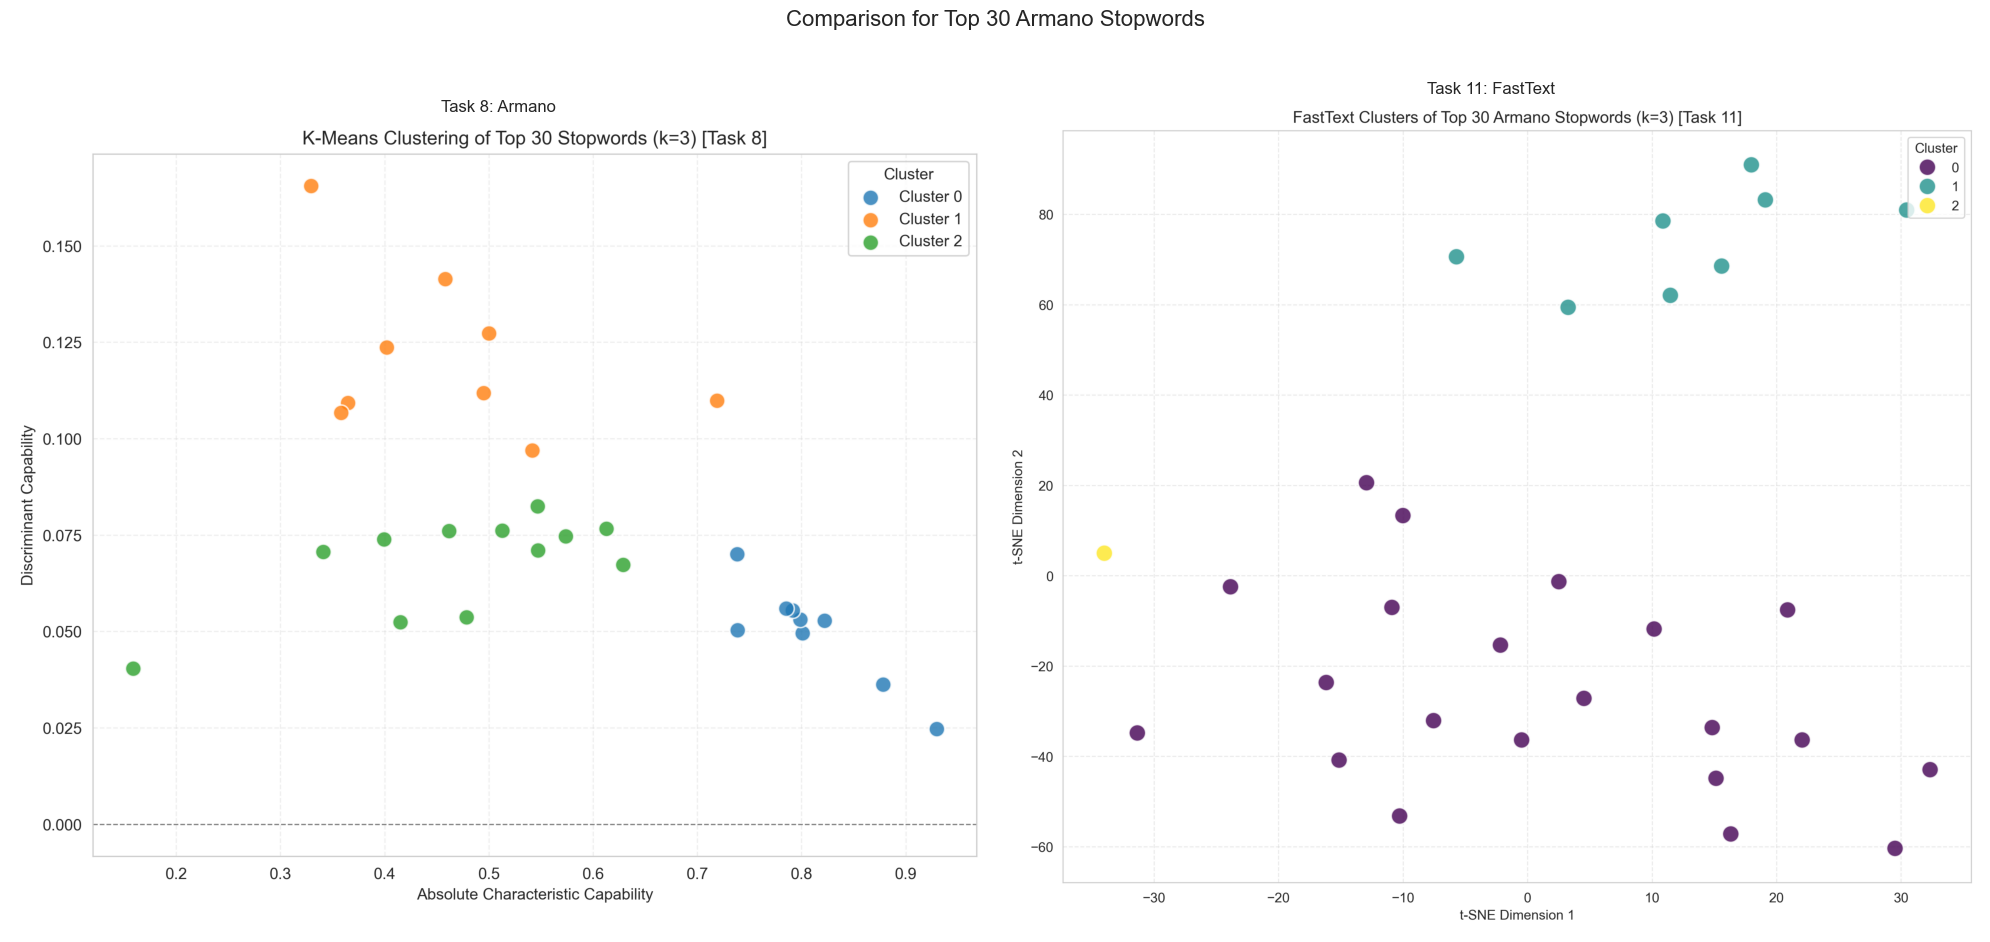

In [25]:



# Comparison for Top 30 Armano Stopwords 


task8_img_path = 'plot/task8.png'
task11_top30_img_path = 'plot/task11_fastText_top30.png'

task9_img_path = 'plot/task9.png'
task11_default_img_path = os.path.join('plot/task11_fastText_default.png')

fig1, axes1 = plt.subplots(1, 2, figsize=(20, 10))
img8 = mpimg.imread(task8_img_path)
axes1[0].imshow(img8)
axes1[0].set_title('Task 8: Armano')
axes1[0].axis('off') 
img11_top30 = mpimg.imread(task11_top30_img_path)
axes1[1].imshow(img11_top30)
axes1[1].set_title('Task 11: FastText')
axes1[1].axis('off')

fig1.suptitle('Comparison for Top 30 Armano Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




In [26]:
print("Creating merged DataFrame with cluster assignments...")


task8_clusters_to_merge = top30_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task8'}
)
task11_clusters_to_merge = cluster_summary_ft_top30[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task11'}
)

# Use outer merge in case some words were missing embeddings in Task 11
merged_clusters = pd.merge(
    task8_clusters_to_merge,
    task11_clusters_to_merge,
    on='word',
    how='outer' # Keep all words from both analyses
)

merged_clusters['Translation'] = translate_words(merged_clusters['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task8', 'cluster_task11']

print("\n==== Merged Cluster Assignments (Task 8 vs Task 11) ====")
print("      (Top 30 Armano Stopwords)")
print(merged_clusters[display_cols].sort_values(by=['cluster_task8', 'cluster_task11']).to_markdown(index=False, floatfmt=".0f"))


Creating merged DataFrame with cluster assignments...

==== Merged Cluster Assignments (Task 8 vs Task 11) ====
      (Top 30 Armano Stopwords)
| word   | Translation   |   cluster_task8 |   cluster_task11 |
|:-------|:--------------|----------------:|-----------------:|
| cho    | give          |               0 |                0 |
| của    | belong to     |               0 |                0 |
| trong  | in            |               0 |                0 |
| với    | with          |               0 |                0 |
| được   | Okay          |               0 |                0 |
| có     | Have          |               0 |                1 |
| là     | To be         |               0 |                1 |
| và     | and           |               0 |                1 |
| đã     | Satisfied     |               0 |                1 |
| các    | the           |               1 |                0 |
| cũng   | also          |               1 |                0 |
| một    | one          

## Findings

1.  **Strong Divergence:** Similar to the Word2Vec comparison, the cluster assignments between Task 8 (statistical) and Task 11 (FastText semantic) show significant differences. Words grouped by φ/δ scores are frequently separated when grouped by FastText similarity, and vice-versa.
   
2.  **Task 8 Clusters (Left Plot):** 
    * Same as before
   
3.  **Task 11 Clusters (Right Plot):**
    * The FastText embeddings, visualized via t-SNE, result in distinct semantic clusters.
    * Cluster 0 (purple) contains the largest group of words, including many common function words (`các`, `khi`, `không`, `người`, `này`, `sau`, `trên`, `vào`, `cũng`, `một`, `ngày`, `nhiều`, `những`, `theo`, `tại`, `đến`, `cho`, `của`, `trong`, `với`, `được`).
  
    * Cluster 1 groups several words like `ra`, `về`, `đó`, `để`, `có`, `là`, `và`, `đã`.
    * Cluster 2 contains only one word (`từ` - from).
  
4.  **Mismatch Examples:**
    * Words in Task 8's Cluster 2 are split across Task 11's Clusters 0 (`cho`, `của`, `trong`, `với`, `được`) and 1 (`có`, `là`, `và`, `đã`).
    * Words in Task 8's Cluster 0 are split across all three Task 11 clusters (e.g., `các`->0, `ra`->1, `từ`->2).
    * Words in Task 8's Cluster 1 are mostly in Task 11's Cluster 0 (e.g., `cũng`, `một`, `ngày`, `nhiều`).

**Interpretation:**

* The FastText-based semantic clustering (Task 11) provides different groupings compared to the statistical clustering based on phi and delta (Task 8). This reinforce the idea that corpus-specific statistical behavior doesn't directly map to general semantic similarity, not for Vietnamese at least.
  
* FastText, like Word2Vec, groups many common function words together (mostly in Cluster 0), suggesting it captures their similar contextual usage. However, the specific cluster assignments differ slightly from Word2Vec (comparing Task 11's table to Task 10's table), indicating subtle differences in how the embedding models represent these words' semantics.
  
* The Armano words, identified by their statistical properties in *this* news dataset, don't necessarily form coherent semantic groups according to FastText embeddings.

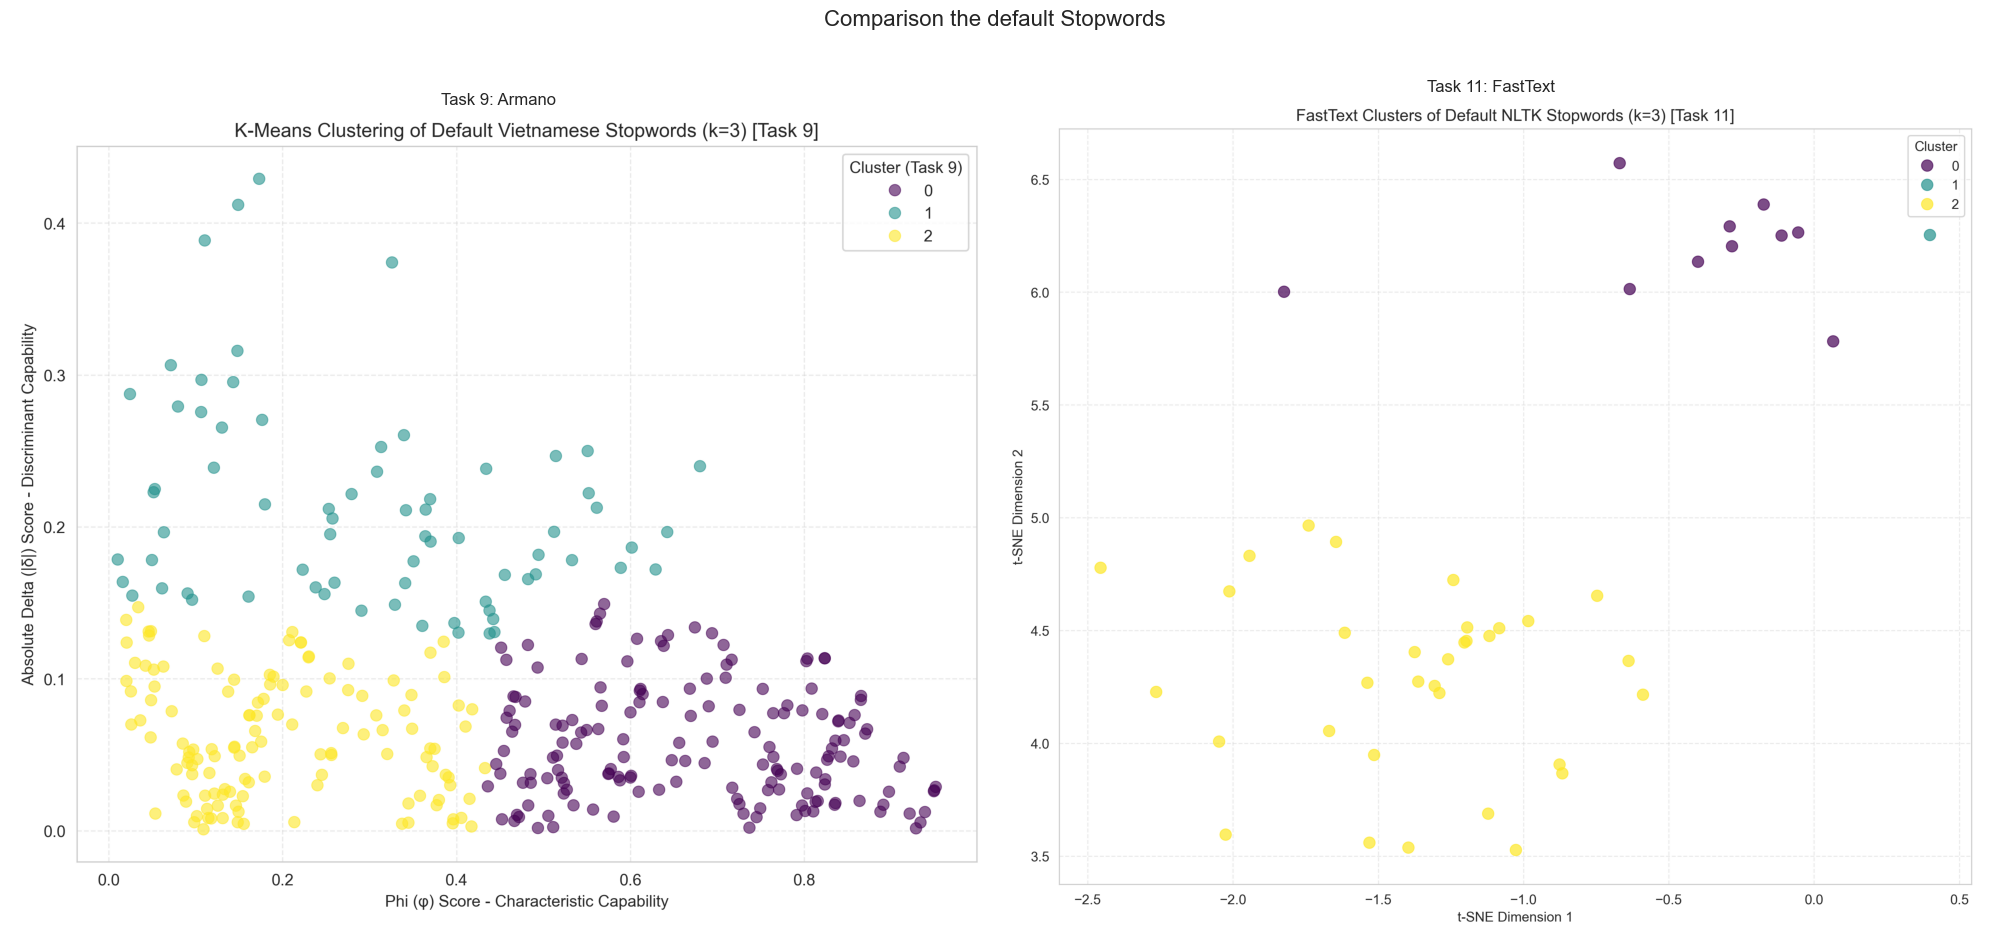

In [27]:
fig1, axes1 = plt.subplots(1, 2, figsize=(20, 10))
img9 = mpimg.imread(task9_img_path)
axes1[0].imshow(img9)
axes1[0].set_title('Task 9: Armano')
axes1[0].axis('off') 
img11_default = mpimg.imread(task11_default_img_path)
axes1[1].imshow(img11_default)
axes1[1].set_title('Task 11: FastText')
axes1[1].axis('off')

fig1.suptitle('Comparison the default Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [28]:
print("Merging Task 9 and Task 11 cluster assignments for common words...")


task9_data_full = default_stopwords_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task9'}
)
task11_data_full = cluster_summary_default[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task11'}
)

# use "inner" because there are a lot 
merged_common_words = pd.merge(
    task9_data_full,
    task11_data_full,
    on='word',
    how='inner' # Keep only words that appear in both dataframes
)

# Check if enough common words exist 
num_common = len(merged_common_words)
sample_size = min(30, num_common) # Take 30 or fewer if less than 30 common words

if num_common < 30:
    print(f"Warning: Only {num_common} words were found in both Task 9 and Task 11 results. Sampling {num_common} words.")
else:
    print(f"Found {num_common} common words. Sampling 30...")


merged_clusters_sample = merged_common_words.sample(n=sample_size, random_state=23) # Use sample_size


print("Adding translations...")
merged_clusters_sample['Translation'] = translate_words(merged_clusters_sample['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task9', 'cluster_task11']




print(f"\n--- Random Sample of {sample_size} Common Words: Cluster Assignments (Task 9 vs Task 11) ---")
# Sort for potentially clearer viewing
print(merged_clusters_sample[display_cols].sort_values(by=['cluster_task9', 'cluster_task11']).to_markdown(index=False, floatfmt=".0f"))

Merging Task 9 and Task 11 cluster assignments for common words...
Found 336 common words. Sampling 30...
Adding translations...

--- Random Sample of 30 Common Words: Cluster Assignments (Task 9 vs Task 11) ---
| word   | Translation   |   cluster_task9 |   cluster_task11 |
|:-------|:--------------|----------------:|-----------------:|
| người  | People        |               0 |                1 |
| vào    | enter         |               0 |                1 |
| từ     | from          |               0 |                1 |
| từ     | from          |               0 |                1 |
| không  | Are not       |               0 |                2 |
| được   | Okay          |               0 |                2 |
| trong  | in            |               0 |                2 |
| cho    | give          |               0 |                2 |
| những  | these         |               0 |                2 |
| của    | belong to     |               0 |                2 |
| các    | the      

## Findings

**Observations from the Plots and Sample Table:** 
1.  **Different Cluster Structures:** The plots clearly show that clustering based on statistical distribution (Task 9, left plot) yields different groupings than clustering based on semantic similarity using FastText (Task 11, right plot). The visual separation and composition of clusters are distinct.
   
2.  **Task 9 Clusters (Left plot)**
    * Same as above
  
3.  **Task 11 Clusters (FastText/t-SNE):**
    * The right plot shows semantic groupings based on FastText, visualized in 2D by t-SNE. Cluster 0 (purple), Cluster 1 (teal), and Cluster 2 (yellow) occupy relatively distinct regions, suggesting FastText captures different contextual patterns.
  
4.  **Mismatch Examples (from Sample Table):**
    * Words from Task 9 Cluster 0 (statistically most "stopword-like") primarily fall into Task 11 Cluster 0 (e.g., `mày`, `răng`, `béng`), but some map to Cluster 1 (`bất_luận`) and Cluster 2 (`cha`, `ít_nhất`). This shows statistical similarity doesn't guarantee semantic similarity.
  
    * Many words from Task 9 Clusters 1 and 2 (intermediate or lower statistical "stopwordness") are grouped together in Task 11 Cluster 2 (e.g., `tính`, `giữa`, `giờ` from T9=1 
    -> T11=2; `cùng`, `cao`, `thấy` from T9=2 -> T11=2). This suggests Task 11 Cluster 2 might represent a broad category of common function words that, while semantically related according to FastText, have varied statistical distributions in this specific news corpus.

**Interpretation:**

Clustering standard Vietnamese stopwords using corpus-specific statistical metrics (Task 9) yields different results than using general semantic embeddings from FastText (Task 11). While Task 9 highlights which stopwords behave most ideally (high spread, low distinctiveness) *within this news dataset*, Task 11 reveals groupings based on broader linguistic context and meaning captured by the FastText model. Neither clustering method perfectly aligns with the other, indicating that statistical behavior in a specific corpus doesn't fully capture the semantic relationships between function words. Task 11 likely provides more intuitive groupings based on word meaning and usage patterns.

Loading cached Task 11 (PhoBERT Top 30) results from pkl_folder\task11_phobert_top30.pkl...
Results loaded.


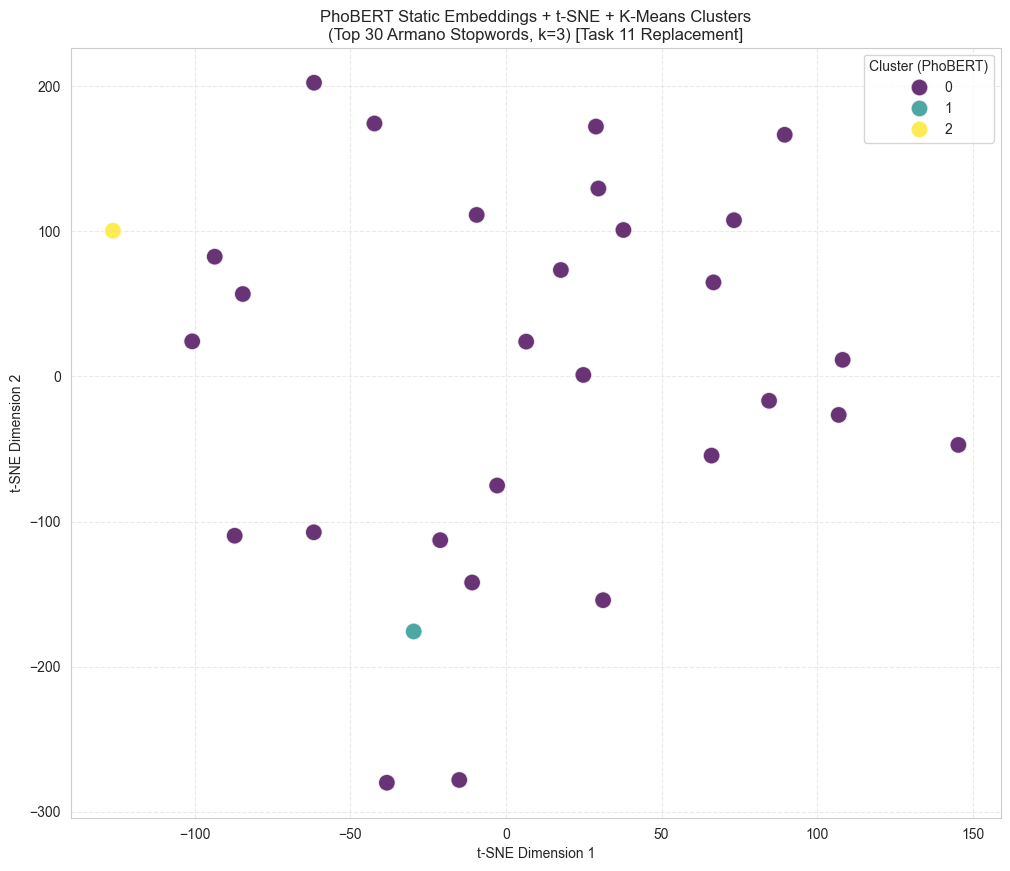

In [29]:

TASK11_PHOBERT_TOP30_PKL = os.path.join(PKL_FOLDER, 'task11_phobert_top30.pkl') 
NUM_CLUSTERS = 3 # Keep consistent


if os.path.exists(TASK11_PHOBERT_TOP30_PKL):
    print(f"Loading cached Task 11 (PhoBERT Top 30) results from {TASK11_PHOBERT_TOP30_PKL}...")
    with open(TASK11_PHOBERT_TOP30_PKL, 'rb') as f:
        cluster_summary_phobert_top30 = pickle.load(f)
        X_tsne_phobert_top30 = pickle.load(f)
    print("Results loaded.")

else:
    print("Cache not found for Task 11 (PhoBERT Top 30). Running analysis...")


    top_terms = top30_cluster_df['word'].tolist()

    X_phobert_top30 = []
    valid_terms_phobert_top30 = []

    print("Extracting PhoBERT static embeddings for Top 30 Armano stopwords...")
    with torch.no_grad(): # Disable gradient calculations for efficiency
        for term in tqdm(top_terms, desc="Embedding extraction (PhoBERT, Top 30)"):

            if term in phobert_vocab:
                token_id = phobert_vocab[term]
                # Get the static embedding vector
                embedding_vector = phobert_embeddings.weight[token_id].cpu().numpy()
                X_phobert_top30.append(embedding_vector)
                valid_terms_phobert_top30.append(term)

                
    X_phobert_top30 = np.array(X_phobert_top30)
    print(f"Found static embeddings for {len(valid_terms_phobert_top30)} / {len(top_terms)} words.")
    if len(valid_terms_phobert_top30) == 0:
        raise ValueError("No PhoBERT embeddings found for Top 30 stopwords (as single tokens).")

    # Cluster on embeddings
    print(f"Running K-Means clustering (k={NUM_CLUSTERS}) on PhoBERT embeddings...")
    kmeans_phobert_top30 = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10) # Changed random state slightly
    # Cluster directly on PhoBERT embeddings (t-SNE is just for visualization)
    clusters_phobert_top30 = kmeans_phobert_top30.fit_predict(X_phobert_top30) 
    print("Clustering completed.")

    print("Running t-SNE for visualization...")
    # Adjust perplexity based on the number of valid terms found
    perplexity_val = min(5, len(valid_terms_phobert_top30) - 1)
    if perplexity_val < 1: perplexity_val = 1

    tsne_phobert_top30 = TSNE(
        n_components=2,
        random_state=2, # Keep consistent random state for t-SNE
        perplexity=perplexity_val,
        init='pca',
    )
    # Fit t-SNE on the original PhoBERT embeddings
    X_tsne_phobert_top30 = tsne_phobert_top30.fit_transform(X_phobert_top30) 
    print("t-SNE completed.")

    # Create summary DataFrame including t-SNE coordinates and clusters
    cluster_summary_phobert_top30 = pd.DataFrame({
        "word": valid_terms_phobert_top30,
        "tsne_1": X_tsne_phobert_top30[:, 0],
        "tsne_2": X_tsne_phobert_top30[:, 1],
        "cluster": clusters_phobert_top30 # Store the clusters found using original embeddings
    })

    print(f"Saving Task 11 (PhoBERT Top 30) results to {TASK11_PHOBERT_TOP30_PKL}...")
    with open(TASK11_PHOBERT_TOP30_PKL, 'wb') as f:
        pickle.dump(cluster_summary_phobert_top30, f)
        pickle.dump(X_tsne_phobert_top30, f) # Save t-SNE coords if needed later
    print("Results saved.")


plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary_phobert_top30,
    x='tsne_1',
    y='tsne_2',
    hue='cluster', # Color by the cluster found on original embeddings
    palette='viridis', # Or another palette
    s=150, alpha=0.8, edgecolor='w'
)


plt.title(f"PhoBERT Static Embeddings + t-SNE + K-Means Clusters\n(Top 30 Armano Stopwords, k={NUM_CLUSTERS}) [Task 11 Replacement]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster (PhoBERT)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig(os.path.join('plot','task11_phobert_top30.png'), dpi=300, bbox_inches='tight') # Optional save
plt.show()



In [30]:
cluster_ids_t11_p1 = sorted(cluster_summary_phobert_top30['cluster'].unique())
for cluster_id in cluster_ids_t11_p1:
        print(f"\nCluster {cluster_id}:")
        # Filter the DataFrame for the current cluster
        subset_df_t11 = cluster_summary_phobert_top30[cluster_summary_phobert_top30['cluster'] == cluster_id].copy()

        # Add translations if translator is available
        if translator:
            # Use the correct column name ('word' or 'term')
            word_col_name = 'word' if 'word' in subset_df_t11.columns else 'term'
            subset_df_t11['Translation'] = translate_words(subset_df_t11[word_col_name].tolist())
            # Display table including translation
            print(subset_df_t11[[word_col_name, 'Translation', 'cluster']].to_markdown(index=False))
        else:
            # Display table without translation
             print("(Translator unavailable)")
             word_col_name = 'word' if 'word' in subset_df_t11.columns else 'term'
             print(subset_df_t11[[word_col_name, 'cluster']].to_markdown(index=False))


Cluster 0:
| word   | Translation   |   cluster |
|:-------|:--------------|----------:|
| và     | and           |         0 |
| của    | belong to     |         0 |
| trong  | in            |         0 |
| được   | Okay          |         0 |
| có     | Have          |         0 |
| cho    | give          |         0 |
| với    | with          |         0 |
| đã     | Satisfied     |         0 |
| các    | the           |         0 |
| để     | to            |         0 |
| khi    | When          |         0 |
| không  | Are not       |         0 |
| đó     | there         |         0 |
| này    | This          |         0 |
| người  | People        |         0 |
| vào    | enter         |         0 |
| từ     | from          |         0 |
| theo   | according to  |         0 |
| một    | one           |         0 |
| ra     | go out        |         0 |
| trên   | above         |         0 |
| đến    | arrive        |         0 |
| những  | these         |         0 |
| sau    | af

Loading cached Task 11 (PhoBERT Top 30) results from pkl_folder\task11_phobert_default.pkl...
Results loaded.


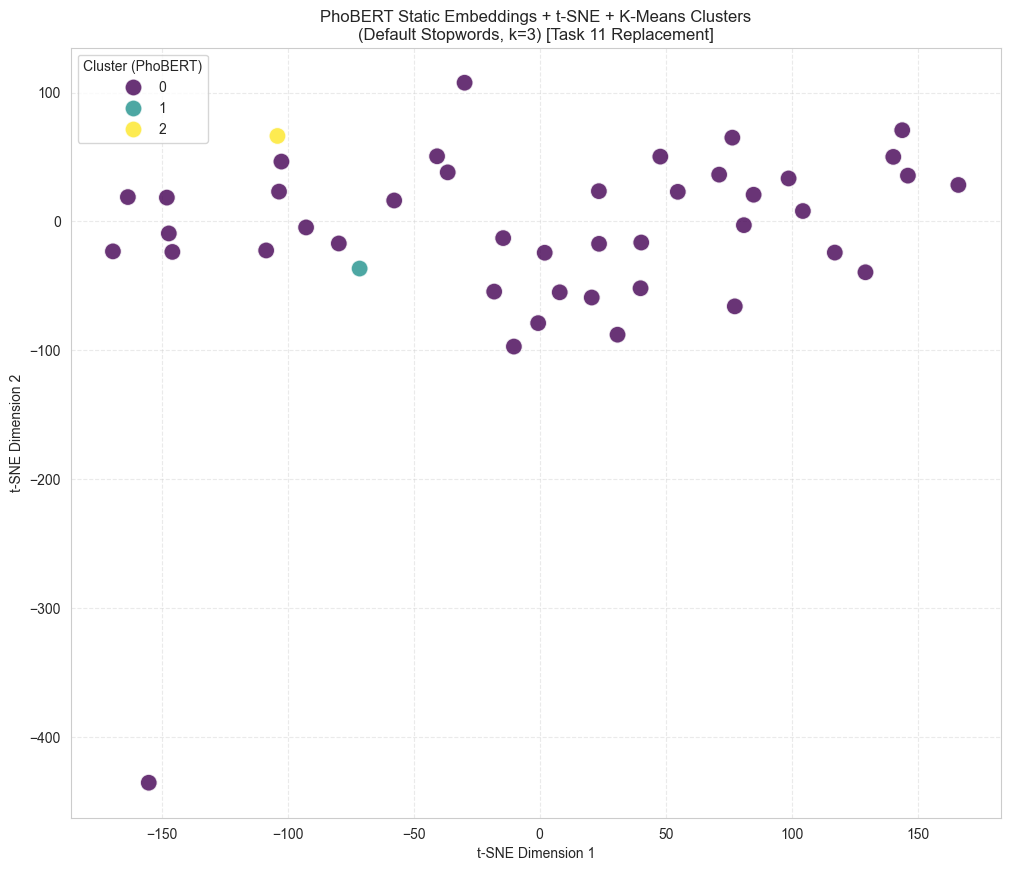

In [31]:

TASK11_PHOBERT_DEFAULT = os.path.join(PKL_FOLDER, 'task11_phobert_default.pkl') 
NUM_CLUSTERS = 3 


if os.path.exists(TASK11_PHOBERT_DEFAULT):
    print(f"Loading cached Task 11 (PhoBERT Top 30) results from {TASK11_PHOBERT_DEFAULT}...")
    with open(TASK11_PHOBERT_DEFAULT, 'rb') as f:
        cluster_summary_phobert_default = pickle.load(f)
        X_tsne_phobert_default = pickle.load(f)
    print("Results loaded.")

else:
    print("Cache not found for Task 11 (PhoBERT Top 30). Running analysis...")


    top_terms = default_stopwords_cluster_df['word'].tolist()

    X_phobert_default = []
    valid_terms_phobert_default = []

    print("Extracting PhoBERT static embeddings for Top 30 Armano stopwords...")
    with torch.no_grad(): # Disable gradient calculations for efficiency
        for term in tqdm(top_terms, desc="Embedding extraction (PhoBERT, Top 30)"):

            if term in phobert_vocab:
                token_id = phobert_vocab[term]
                # Get the static embedding vector
                embedding_vector = phobert_embeddings.weight[token_id].cpu().numpy()
                X_phobert_default.append(embedding_vector)
                valid_terms_phobert_default.append(term)

                
    X_phobert_default = np.array(X_phobert_default)
    print(f"Found static embeddings for {len(valid_terms_phobert_default)} / {len(top_terms)} words.")
    if len(valid_terms_phobert_default) == 0:
        raise ValueError("No PhoBERT embeddings found for Top 30 stopwords (as single tokens).")

    # Cluster on embeddings
    print(f"Running K-Means clustering (k={NUM_CLUSTERS}) on PhoBERT embeddings...")
    kmeans_phobert_default = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10) # Changed random state slightly
    # Cluster directly on PhoBERT embeddings (t-SNE is just for visualization)
    cluster_summary_phobert_default = kmeans_phobert_default.fit_predict(X_phobert_default) 
    print("Clustering completed.")

    print("Running t-SNE for visualization...")
    # Adjust perplexity based on the number of valid terms found
    perplexity_val = min(5, len(valid_terms_phobert_default) - 1)
    if perplexity_val < 1: perplexity_val = 1

    tsne_phobert_default = TSNE(
        n_components=2,
        random_state=2, # Keep consistent random state for t-SNE
        perplexity=perplexity_val,
        init='pca',
    )
    # Fit t-SNE on the original PhoBERT embeddings
    X_tsne_phobert_default = tsne_phobert_default.fit_transform(X_phobert_default) 
    print("t-SNE completed.")

    # Create summary DataFrame including t-SNE coordinates and clusters
    cluster_summary_phobert_default = pd.DataFrame({
        "word": valid_terms_phobert_default,
        "tsne_1": X_tsne_phobert_default[:, 0],
        "tsne_2": X_tsne_phobert_default[:, 1],
        "cluster": cluster_summary_phobert_default # Store the clusters found using original embeddings
    })

    print(f"Saving Task 11 (PhoBERT Top 30) results to {TASK11_PHOBERT_DEFAULT}...")
    with open(TASK11_PHOBERT_DEFAULT, 'wb') as f:
        pickle.dump(cluster_summary_phobert_default, f)
        pickle.dump(X_tsne_phobert_default, f) # Save t-SNE coords if needed later
    print("Results saved.")

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary_phobert_default,
    x='tsne_1',
    y='tsne_2',
    hue='cluster', # Color by the cluster found on original embeddings
    palette='viridis', # Or another palette
    s=150, alpha=0.8, edgecolor='w'
)


plt.title(f"PhoBERT Static Embeddings + t-SNE + K-Means Clusters\n(Default Stopwords, k={NUM_CLUSTERS}) [Task 11 Replacement]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster (PhoBERT)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig(os.path.join('plot','task11_phobert_default.png'), dpi=300, bbox_inches='tight') # Optional save
plt.show()



In [32]:
cluster_ids_t11_p1 = sorted(cluster_summary_phobert_default['cluster'].unique())
for cluster_id in cluster_ids_t11_p1:
    print(f"\nCluster {cluster_id}:")
    # Filter the DataFrame for the current cluster
    subset_df_t11 = cluster_summary_phobert_default[cluster_summary_phobert_default['cluster'] == cluster_id].copy()

    # Add translations if translator is available
    if translator:
        # Use the correct column name ('word' or 'term')
        word_col_name = 'word' if 'word' in subset_df_t11.columns else 'term'
        subset_df_t11['Translation'] = translate_words(subset_df_t11[word_col_name].tolist())
        # Display table including translation
        print(subset_df_t11[[word_col_name, 'Translation', 'cluster']].to_markdown(index=False))
    else:
        # Display table without translation
         print("(Translator unavailable)")
         word_col_name = 'word' if 'word' in subset_df_t11.columns else 'term'
         print(subset_df_t11[[word_col_name, 'cluster']].to_markdown(index=False))


Cluster 0:
| word   | Translation   |   cluster |
|:-------|:--------------|----------:|
| năm    | year          |         0 |
| này    | This          |         0 |
| trên   | above         |         0 |
| từ     | from          |         0 |
| việc   | job           |         0 |
| trước  | before        |         0 |
| vào    | enter         |         0 |
| sau    | after         |         0 |
| người  | People        |         0 |
| một    | one           |         0 |
| sẽ     | will          |         0 |
| của    | belong to     |         0 |
| không  | Are not       |         0 |
| biết   | know          |         0 |
| nhưng  | But           |         0 |
| về     | about         |         0 |
| đó     | there         |         0 |
| khi    | When          |         0 |
| đã     | Satisfied     |         0 |
| những  | these         |         0 |
| các    | the           |         0 |
| trong  | in            |         0 |
| theo   | according to  |         0 |
| cũng   | al

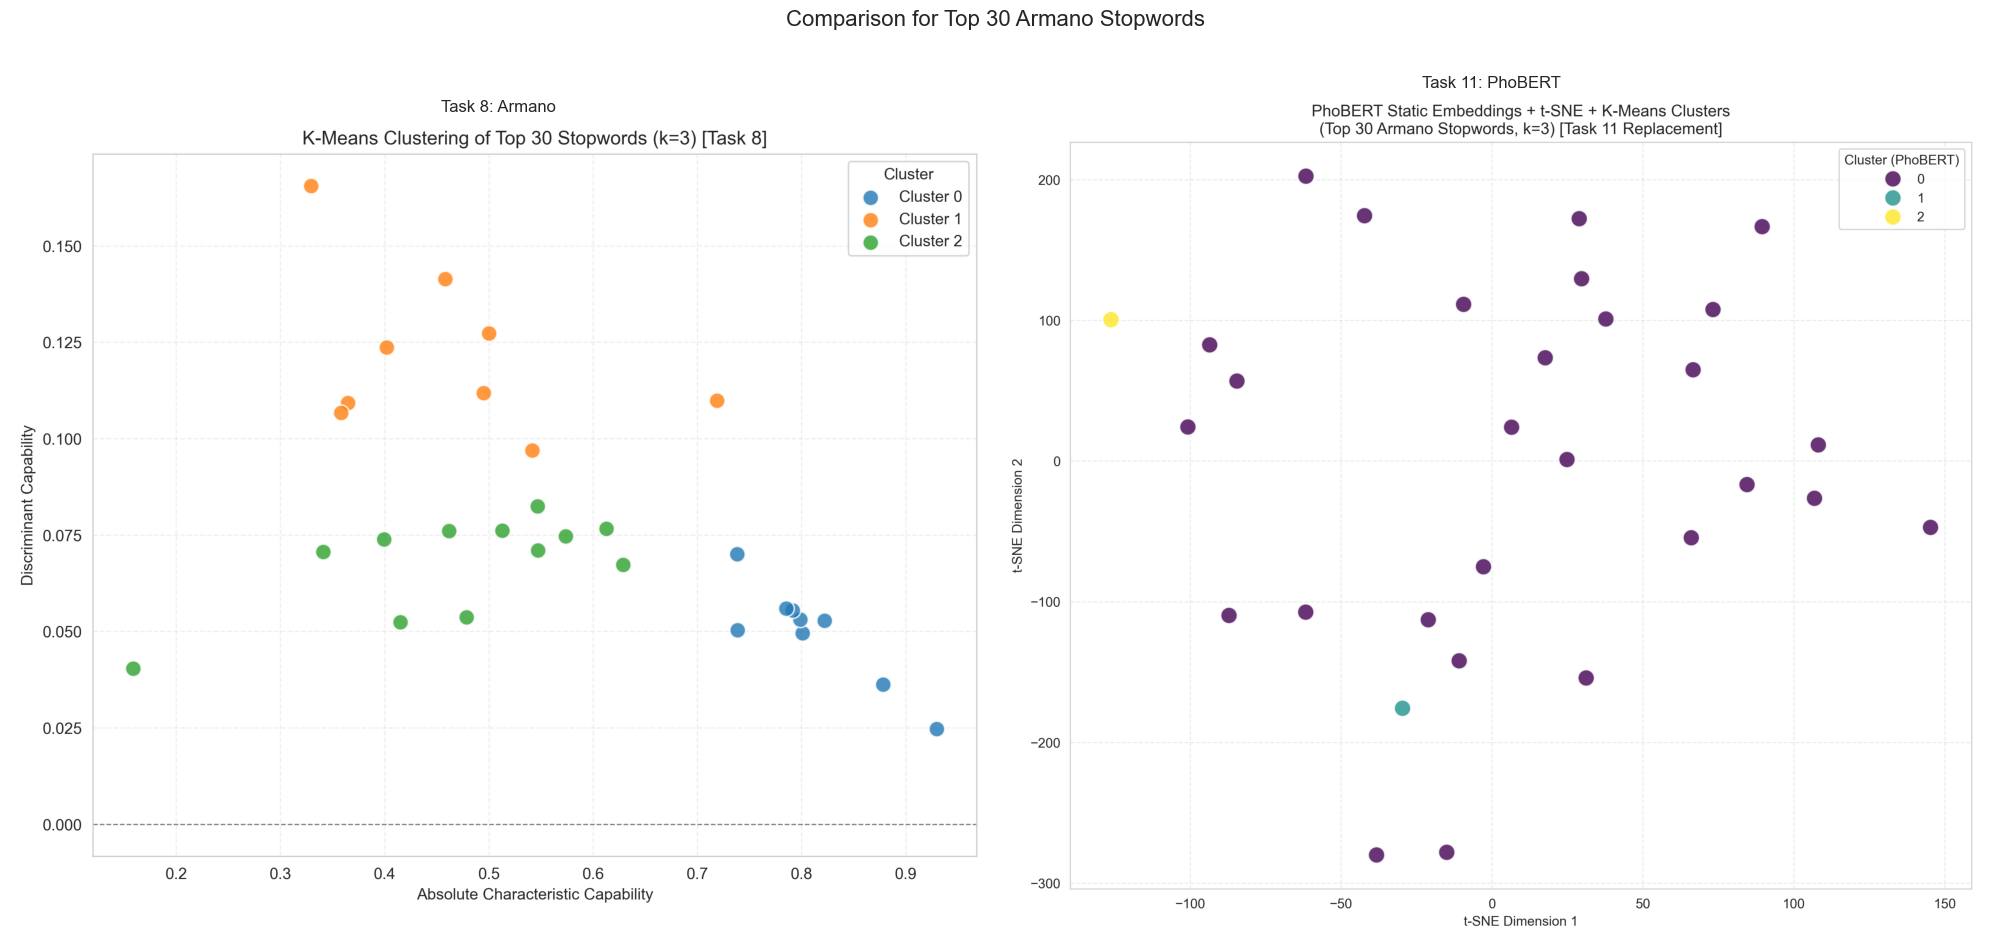

In [33]:


# Comparison for Top 30 Armano Stopwords 

task8_img_path = 'plot/task8.png'
task11_top30_img_path = 'plot/task11_phobert_top30.png'

task9_img_path = 'plot/task9.png'
task11_default_img_path = os.path.join('plot/task11_phobert_default.png')

fig1, axes1 = plt.subplots(1, 2, figsize=(20, 10))
img8 = mpimg.imread(task8_img_path)
axes1[0].imshow(img8)
axes1[0].set_title('Task 8: Armano')
axes1[0].axis('off') 
img11_top30 = mpimg.imread(task11_top30_img_path)
axes1[1].imshow(img11_top30)
axes1[1].set_title('Task 11: PhoBERT')
axes1[1].axis('off')

fig1.suptitle('Comparison for Top 30 Armano Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




In [34]:
print("Creating merged DataFrame with cluster assignments...")


task8_clusters_to_merge = top30_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task8'}
)
task11_clusters_to_merge = cluster_summary_phobert_top30[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task11'}
)

# Use outer merge in case some words were missing embeddings in Task 11
merged_clusters = pd.merge(
    task8_clusters_to_merge,
    task11_clusters_to_merge,
    on='word',
    how='outer' # Keep all words from both analyses
)

merged_clusters['Translation'] = translate_words(merged_clusters['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task8', 'cluster_task11']

print("\n==== Merged Cluster Assignments (Task 8 vs Task 11) ====")
print("      (Top 30 Armano Stopwords)")
print(merged_clusters[display_cols].sort_values(by=['cluster_task8', 'cluster_task11']).to_markdown(index=False, floatfmt=".0f"))


Creating merged DataFrame with cluster assignments...

==== Merged Cluster Assignments (Task 8 vs Task 11) ====
      (Top 30 Armano Stopwords)
| word   | Translation   |   cluster_task8 |   cluster_task11 |
|:-------|:--------------|----------------:|-----------------:|
| cho    | give          |               0 |                0 |
| có     | Have          |               0 |                0 |
| của    | belong to     |               0 |                0 |
| trong  | in            |               0 |                0 |
| và     | and           |               0 |                0 |
| với    | with          |               0 |                0 |
| đã     | Satisfied     |               0 |                0 |
| được   | Okay          |               0 |                0 |
| là     | To be         |               0 |                1 |
| các    | the           |               1 |                0 |
| cũng   | also          |               1 |                0 |
| một    | one          

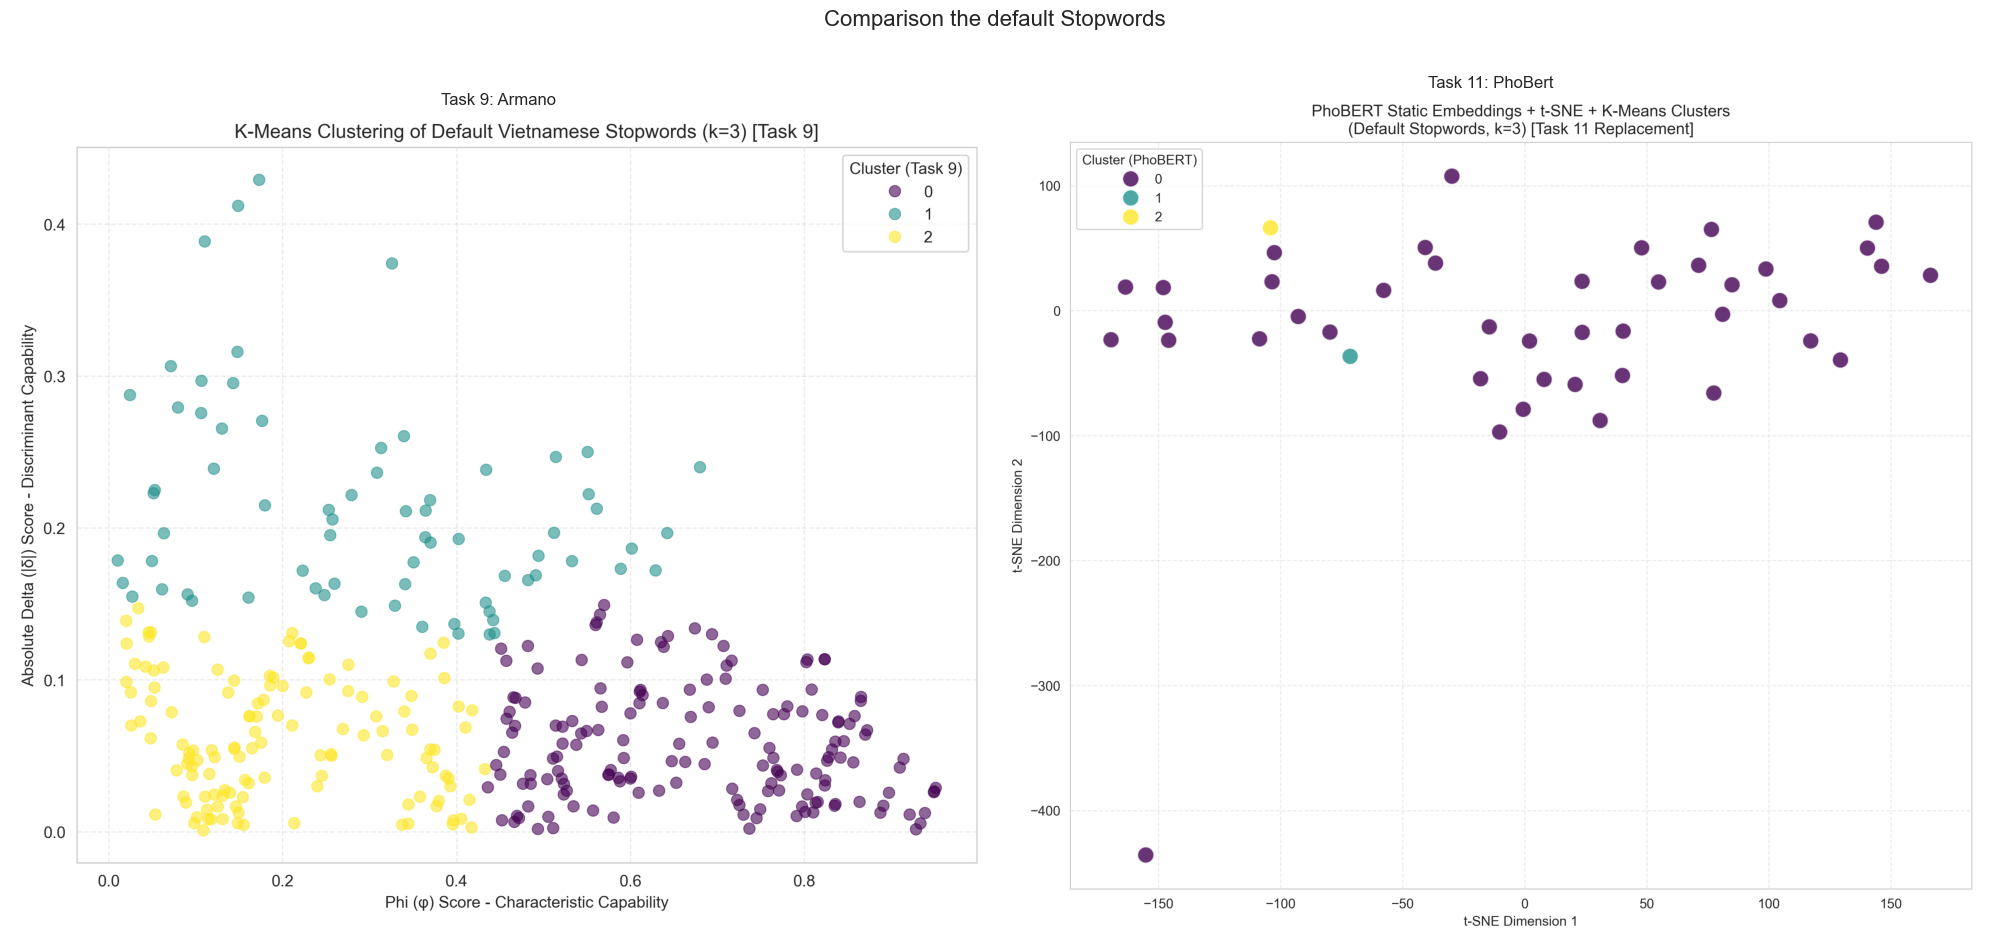

In [35]:
fig1, axes1 = plt.subplots(1, 2, figsize=(20, 10))
img9 = mpimg.imread(task9_img_path)
axes1[0].imshow(img9)
axes1[0].set_title('Task 9: Armano')
axes1[0].axis('off') 
img11_default = mpimg.imread(task11_default_img_path)
axes1[1].imshow(img11_default)
axes1[1].set_title('Task 11: PhoBert')
axes1[1].axis('off')

fig1.suptitle('Comparison the default Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [36]:
print("Merging Task 9 and Task 11 cluster assignments for common words...")


task9_data_full = default_stopwords_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task9'}
)
task11_data_full = cluster_summary_phobert_default[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task11'}
)

# use "inner" because there are a lot 
merged_common_words = pd.merge(
    task9_data_full,
    task11_data_full,
    on='word',
    how='inner' # Keep only words that appear in both dataframes
)

num_common = len(merged_common_words)
sample_size = min(30, num_common) # Take 30 or fewer if less than 30 common words

if num_common < 30:
    print(f"Warning: Only {num_common} words were found in both Task 9 and Task 11 results. Sampling {num_common} words.")
else:
    print(f"Found {num_common} common words. Sampling 30...")


merged_clusters_sample = merged_common_words.sample(n=sample_size, random_state=23) # Use sample_size


print("Adding translations...")
merged_clusters_sample['Translation'] = translate_words(merged_clusters_sample['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task9', 'cluster_task11']




print(f"\n--- Random Sample of {sample_size} Common Words: Cluster Assignments (Task 9 vs Task 11) ---")
# Sort for potentially clearer viewing
print(merged_clusters_sample[display_cols].sort_values(by=['cluster_task9', 'cluster_task11']).to_markdown(index=False, floatfmt=".0f"))

Merging Task 9 and Task 11 cluster assignments for common words...
Found 336 common words. Sampling 30...
Adding translations...

--- Random Sample of 30 Common Words: Cluster Assignments (Task 9 vs Task 11) ---
| word   | Translation   |   cluster_task9 |   cluster_task11 |
|:-------|:--------------|----------------:|-----------------:|
| không  | Are not       |               0 |                0 |
| người  | People        |               0 |                0 |
| trong  | in            |               0 |                0 |
| cho    | give          |               0 |                0 |
| vào    | enter         |               0 |                0 |
| những  | these         |               0 |                0 |
| của    | belong to     |               0 |                0 |
| các    | the           |               0 |                0 |
| có     | Have          |               0 |                0 |
| từ     | Error         |               0 |                0 |
| có     | Have     